<a href="https://colab.research.google.com/github/sheldonkemper/bank_of_england/blob/main/notebooks/modelling/am_topic_merged_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective: Automated Financial Topic Modeling & Sentiment Analysis**
The primary objective of this code is to extract, analyze, and categorize financial discussions from quarterly reports and management discussions using multiple NLP-based topic modeling approaches. The code aims to identify key themes and track topic trends over time while also incorporating sentiment analysis to assess the tone of discussions.

To achieve this, the code integrates a variety of topic modeling techniques, including probabilistic, clustering-based, and transformer-based approaches, ensuring a comprehensive and comparative analysis of financial text.

# **Key Approaches**
LDA (Latent Dirichlet Allocation)

BERTopic (HDBSCAN)

BERTopic + FinBERT

Falcon models both LLM and light instruct model (Failed as notebook crashed. Thus excluded)

GPT model - GPT-4-Turbo

# **Section 1: Libraries & Package installation**

In [ ]:
!pip install -q bertopic
!pip install -q umap-learn
!pip install -q hdbscan
!pip install -q sentence-transformers
!pip install -q bertopic sentence-transformers gensim scikit-learn transformers nltk
!pip install -q pyLDAvis
!pip install -q python-dotenv

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
from transformers import pipeline
import nltk
from nltk.tokenize import word_tokenize
import string
import os

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic
from hdbscan import HDBSCAN
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer
from sklearn.cluster import KMeans
import string
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from nltk.tokenize import sent_tokenize
import json
import time

In [ ]:
# Download NLTK resources (run these lines once)
nltk.download('punkt')
nltk.download('stopwords')
# Download the punkt_tab data package
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
input_df = pd.read_csv("/content/tqc_JPMorgan_answer_topic.csv")

In [ ]:
# Copy the first 5 rows of input_df
input_df = input_df.head(5).copy()

# **Section 2: Topic Modelling: Data --> LDA**

In [ ]:
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from itertools import combinations
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict
import string

nltk.download('punkt')
nltk.download('stopwords')

# Load DataFrame
df = input_df.copy()  # Your dataframe
df = df.dropna(subset=['Response_cleaned'])  # Drop NaNs

# ==============================
# 1. TEXT PREPROCESSING
# ==============================
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text.lower())  # Tokenization & lowercase
    words = [w for w in words if w not in stop_words and w not in string.punctuation]  # Remove stopwords & punctuation
    return words

df['processed_text'] = df['Response_cleaned'].apply(preprocess_text)

# ==============================
# 2. LDA TOPIC MODELING
# ==============================
# Create Dictionary and Corpus
dictionary = corpora.Dictionary(df['processed_text'])
corpus = [dictionary.doc2bow(text) for text in df['processed_text']]

# Train LDA Model
num_topics = 5  # Adjust based on your data
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)

# Extract Topics
topics = lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False)
topics_dict = {i: [word[0] for word in topic[1]] for i, topic in enumerate(topics)}

print("\n=== LDA Topics ===")
for topic_id, words in topics_dict.items():
    print(f"Topic {topic_id}: {', '.join(words)}")

# ==============================
# 3. TOPIC COHERENCE
# ==============================
coherence_model = CoherenceModel(model=lda_model, texts=df['processed_text'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"\nTopic Coherence (C_V): {coherence_score:.4f}")

# ==============================
# 4. TOPIC DIVERSITY (Jaccard Similarity)
# ==============================
def jaccard_similarity(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

topic_word_sets = [set(words) for words in topics_dict.values()]
jaccard_scores = [jaccard_similarity(a, b) for a, b in combinations(topic_word_sets, 2)]
avg_jaccard = np.mean(jaccard_scores)

print(f"Topic Diversity (Avg Jaccard Similarity): {avg_jaccard:.4f}")

# ==============================
# 5. SENTIMENT CONSISTENCY (FinBERT)
# ==============================
finbert_sentiment = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")

def get_topic_sentiments(topics, df):
    topic_sentiments = defaultdict(list)

    for topic_id, words in topics.items():
        relevant_texts = df[df['processed_text'].apply(lambda x: any(word in x for word in words))]['Response_cleaned']

        if len(relevant_texts) > 0:
            sentiments = [finbert_sentiment(text[:512])[0]['label'] for text in relevant_texts]  # Limit text length
            topic_sentiments[topic_id] = sentiments

    return topic_sentiments

topic_sentiments = get_topic_sentiments(topics_dict, df)

print("\n=== Sentiment Analysis per Topic ===")
for topic_id, sentiments in topic_sentiments.items():
    sentiment_counts = pd.Series(sentiments).value_counts(normalize=True).to_dict()
    print(f"Topic {topic_id}: {sentiment_counts}")

# ==============================
# 6. SIMILARITY TO PREDEFINED TOPICS (TF-IDF & Cosine Similarity)
# ==============================
predefined_topics = [
    "revenue growth profitability",
    "regulatory compliance risk",
    "operational costs efficiency",
    "customer satisfaction service",
    "market expansion strategy"
]

extracted_topic_words = [" ".join(words) for words in topics_dict.values()]
vectorizer = TfidfVectorizer()
topic_vectors = vectorizer.fit_transform(extracted_topic_words + predefined_topics)
similarity_matrix = cosine_similarity(topic_vectors[:len(extracted_topic_words)], topic_vectors[len(extracted_topic_words):])

avg_similarity = similarity_matrix.mean()
print(f"\nTopic Similarity to Predefined Topics (Cosine): {avg_similarity:.4f}")

# ==============================
# 7. TOPIC STABILITY (Splitting Data)
# ==============================
df_shuffled = df.sample(frac=1, random_state=42)  # Shuffle dataset
df_part1 = df_shuffled.iloc[:len(df)//2]
df_part2 = df_shuffled.iloc[len(df)//2:]

corpus_part1 = [dictionary.doc2bow(text) for text in df_part1['processed_text']]
corpus_part2 = [dictionary.doc2bow(text) for text in df_part2['processed_text']]

lda_part1 = gensim.models.LdaModel(corpus=corpus_part1, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)
lda_part2 = gensim.models.LdaModel(corpus=corpus_part2, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)

topics_part1 = {i: [word[0] for word in topic[1]] for i, topic in enumerate(lda_part1.show_topics(num_topics=num_topics, num_words=10, formatted=False))}
topics_part2 = {i: [word[0] for word in topic[1]] for i, topic in enumerate(lda_part2.show_topics(num_topics=num_topics, num_words=10, formatted=False))}

# Compute Jaccard Similarity Between Two Runs
stability_scores = [jaccard_similarity(set(topics_part1[i]), set(topics_part2[i])) for i in range(num_topics)]
avg_stability = np.mean(stability_scores)

print(f"\nTopic Stability (Jaccard Between Two Runs): {avg_stability:.4f}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



=== LDA Topics ===
Topic 0: company, lot, focus, current, efficiency, growth, thats, also, means, good
Topic 1: growth, means, company, think, focus, efficiency, always, areas, well, bit
Topic 2: company, growth, efficiency, bit, lot, would, current, focus, thats, means
Topic 3: efficiency, company, growth, think, focus, current, means, would, always, good
Topic 4: efficiency, growth, current, think, well, means, good, bit, company, lot

Topic Coherence (C_V): 0.2383
Topic Diversity (Avg Jaccard Similarity): 0.5198


Device set to use cpu



=== Sentiment Analysis per Topic ===
Topic 0: {'Positive': 1.0}
Topic 1: {'Positive': 1.0}
Topic 2: {'Positive': 1.0}
Topic 3: {'Positive': 1.0}
Topic 4: {'Positive': 1.0}

Topic Similarity to Predefined Topics (Cosine): 0.0346

Topic Stability (Jaccard Between Two Runs): 1.0000


# **Section 3: Topic Modelling: Data --> BERTopic**

In [ ]:
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from itertools import combinations
import numpy as np
from transformers import pipeline
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

# Load DataFrame
df = input_df.copy()
df = df.dropna(subset=['Response_cleaned'])  # Drop NaNs

# ==============================
# 1. TEXT PREPROCESSING
# ==============================
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text.lower())  # Tokenization & lowercase
    words = [w for w in words if w not in stop_words and w not in string.punctuation]  # Remove stopwords & punctuation
    return " ".join(words)

df['processed_text'] = df['Response_cleaned'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df

,Quarter,Question,Question_cleaned,Analyst,Analyst Role,Response,Response_cleaned,Executive,Executive Role Type,Topic,Snippet,processed_text
0,4Q24,"Hi. Good morning. Jeremy, I wanted to ask abou...",['hi good morning jeremy wanted ask capital kn...,John McDonald,"Analyst, Truist Securities, Inc.","Yeah. Good question, John, and welcome back, b...",['yeah good question john welcome back way so ...,Jeremy Barnum,CFO,Capital Deployment Strategy,noted points always make repeat them think way...,'yeah good question john welcome back way yeah...
1,4Q24,"Hi. Good morning. Jeremy, I wanted to ask abou...",['hi good morning jeremy wanted ask capital kn...,John McDonald,"Analyst, Truist Securities, Inc.","Yeah. Good question, John, and welcome back, b...",['yeah good question john welcome back way so ...,Jeremy Barnum,CFO,Strategic Financial Decisions,feels like correct kind strategic financial de...,'yeah good question john welcome back way yeah...
2,4Q24,"Hi. Good morning. Jeremy, I wanted to ask abou...",['hi good morning jeremy wanted ask capital kn...,John McDonald,"Analyst, Truist Securities, Inc.","Yeah. Good question, John, and welcome back, b...",['yeah good question john welcome back way so ...,Jeremy Barnum,CFO,Organic Capital Generation and Return,given amount organic capital generation produc...,'yeah good question john welcome back way yeah...
3,4Q24,"Hi. Good morning. Jeremy, I wanted to ask abou...",['hi good morning jeremy wanted ask capital kn...,John McDonald,"Analyst, Truist Securities, Inc.","Yeah. Good question, John, and welcome back, b...",['yeah good question john welcome back way so ...,Jeremy Barnum,CFO,Investment Focus and Company Culture,in terms high certainty investment choices acr...,'yeah good question john welcome back way yeah...
4,4Q24,"Hi. Good morning. Jeremy, I wanted to ask abou...",['hi good morning jeremy wanted ask capital kn...,John McDonald,"Analyst, Truist Securities, Inc.","Yeah. Good question, John, and welcome back, b...",['yeah good question john welcome back way so ...,Jeremy Barnum,CFO,Technology and Efficiency,starters putting lot effort improving sort abi...,'yeah good question john welcome back way yeah...


In [ ]:
from bertopic import BERTopic
import textwrap

# Merge all processed text into one large document
merged_text = " ".join(df['processed_text'].tolist())

# Split the large text into smaller chunks (e.g., ~50 words per pseudo-document)
chunk_size = 50  # Adjust as needed
pseudo_documents = textwrap.wrap(merged_text, width=chunk_size)

print(f"Total pseudo-documents created: {len(pseudo_documents)}")

Total pseudo-documents created: 325


In [ ]:
# Run BERTopic on these pseudo-documents
topic_model = BERTopic(language="english", calculate_probabilities=True)
topics, probs = topic_model.fit_transform(pseudo_documents)

# Get and print topic information
topic_info = topic_model.get_topic_info()
print("\n=== Extracted Topics ===")
print(topic_info)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


=== Extracted Topics ===
    Topic  Count                                       Name  \
0      -1     22               -1_risk_aggregate_reds_every   
1       0     46            0_efficiency_focus_current_well   
2       1     30                     1_always_yeah_peak_way   
3       2     30           2_culture_bank_deployment_chance   
4       3     30  3_margin_trajectory_opportunities_company   
5       4     30           4_certainty_kind_high_investment   
6       5     30         5_analyzing_exceptions_things_ways   
7       6     25                  6_excess_enough_given_bit   
8       7     22               7_organic_equal_else_capital   
9       8     15           8_consistent_themes_feel_broadly   
10      9     15         9_focus_internal_engineers_example   
11     10     15                    10_head_count_lead_flat   
12     11     15            11_headcount_growth_budget_year   

                                       Representation  \
0   [risk, aggregate, reds, every,

In [ ]:
# ==============================
# 3. TOPIC COHERENCE
# ==============================
texts = [text.split() for text in df]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Get topics from the BERTopic model
topic_info_df = topic_model.get_topic_info()
#topics_dict = {row['Topic']: row['Representation'].split() for _, row in topic_info_df.iterrows() if row['Topic'] != -1}
topics_dict = {row['Topic']: row['Representation'] for _, row in topic_info_df.iterrows() if row['Topic'] != -1}

# Now calculate coherence with the updated topics_dict
coherence_model = CoherenceModel(topics=list(topics_dict.values()), texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"\nTopic Coherence (C_V): {coherence_score:.4f}")


Topic Coherence (C_V): 0.3035


In [ ]:
# ==============================
# 4. TOPIC DIVERSITY (Jaccard Similarity)
# ==============================
def jaccard_similarity(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

topic_word_sets = [set(words) for words in topics_dict.values()]
jaccard_scores = [jaccard_similarity(a, b) for a, b in combinations(topic_word_sets, 2)]
avg_jaccard = np.mean(jaccard_scores)

print(f"Topic Diversity (Avg Jaccard Similarity): {avg_jaccard:.4f}")

Topic Diversity (Avg Jaccard Similarity): 0.0016


In [ ]:
df

["'yeah good question john welcome back way yeah",
 'noted points always make repeat think way thinking',
 'right feel comfortable notion makes sense us nice',
 'store extra capital light current environment',
 'believe theres good chance moment get deploy',
 'better levels essentially whatever way current',
 'opportunities would suggest feels like correct',
 'kind strategic financial decision us said studied',
 'quite extensively last six months debates would',
 'expect concluded enough enough excess given would',
 'like excess grow think implications given amount',
 'organic capital generation producing means unless',
 'find near term opportunities organic deployment',
 'otherwise means capital return buybacks else equal',
 'order arrest growth excess current plan although',
 'give caveat know disclosure want get business',
 'guiding buybacks reserve right change trajectory',
 'time reason current thinking sure truth â€ “ guess',
 'good thing themes remarkably consistent seeing',
 'r

In [ ]:
# ==============================
# 5. SENTIMENT CONSISTENCY (FinBERT)
# ==============================
finbert_sentiment = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")

def get_topic_sentiments(topics, df):
    topic_sentiments = {}

    for topic_id, words in topics.items():
        relevant_texts = df

        if len(relevant_texts) > 0:
            sentiments = [finbert_sentiment(text[:512])[0]['label'] for text in relevant_texts]  # Limit text length
            topic_sentiments[topic_id] = sentiments

    return topic_sentiments

#topic_sentiments = get_topic_sentiments(topics_dict, df)
# After Correction
topic_sentiments = get_topic_sentiments(topics_dict, input_df)

print("\n=== Sentiment Analysis per Topic ===")
for topic_id, sentiments in topic_sentiments.items():
    sentiment_counts = pd.Series(sentiments).value_counts(normalize=True).to_dict()
    print(f"Topic {topic_id}: {sentiment_counts}")

Device set to use cpu



=== Sentiment Analysis per Topic ===
Topic 0: {'Neutral': 1.0}
Topic 1: {'Neutral': 1.0}
Topic 2: {'Neutral': 1.0}
Topic 3: {'Neutral': 1.0}
Topic 4: {'Neutral': 1.0}
Topic 5: {'Neutral': 1.0}
Topic 6: {'Neutral': 1.0}
Topic 7: {'Neutral': 1.0}
Topic 8: {'Neutral': 1.0}
Topic 9: {'Neutral': 1.0}
Topic 10: {'Neutral': 1.0}
Topic 11: {'Neutral': 1.0}


In [ ]:
# ==============================
# 6. SIMILARITY TO PREDEFINED TOPICS (TF-IDF & Cosine Similarity)
# ==============================
predefined_topics = [
    "revenue growth profitability",
    "regulatory compliance risk",
    "operational costs efficiency",
    "market expansion strategy"
]

extracted_topic_words = [" ".join(words) for words in topics_dict.values()]
vectorizer = TfidfVectorizer()
topic_vectors = vectorizer.fit_transform(extracted_topic_words + predefined_topics)
similarity_matrix = cosine_similarity(topic_vectors[:len(extracted_topic_words)], topic_vectors[len(extracted_topic_words):])

avg_similarity = similarity_matrix.mean()
print(f"\nTopic Similarity to Predefined Topics (Cosine): {avg_similarity:.4f}")


Topic Similarity to Predefined Topics (Cosine): 0.0081


In [ ]:
df=input_df.copy()

In [ ]:
# ==============================
# 7. TOPIC STABILITY (Splitting Data)
# ==============================
df_shuffled = df.sample(frac=1, random_state=42)  # Shuffle dataset
df_part1 = df_shuffled.iloc[:len(df)//2]
df_part2 = df_shuffled.iloc[len(df)//2:]

topic_model_part1 = BERTopic(language="english", calculate_probabilities=True)
topics_part1, _ = topic_model_part1.fit_transform(pseudo_documents)
# topics_part1 is already a list, no need to convert
#topics_part1 = topics_part1.tolist()

topic_model_part2 = BERTopic(language="english", calculate_probabilities=True)
topics_part2, _ = topic_model_part2.fit_transform(pseudo_documents)

topic_info_part1 = topic_model_part1.get_topic_info()
topic_info_part2 = topic_model_part2.get_topic_info()

#topics_dict_part1 = {row["Topic"]: row["Representation"].split() for _, row in topic_info_part1.iterrows() if row["Topic"] != -1}
#topics_dict_part2 = {row["Topic"]: row["Representation"].split() for _, row in topic_info_part2.iterrows() if row["Topic"] != -1}
topics_dict_part1 = {row['Topic']: row['Representation'] for _, row in topic_info_df.iterrows() if row['Topic'] != -1}
topics_dict_part2 = {row['Topic']: row['Representation'] for _, row in topic_info_df.iterrows() if row['Topic'] != -1}

# Compute Jaccard Similarity Between Two Runs
stability_scores = [jaccard_similarity(set(topics_dict_part1[i]), set(topics_dict_part2[i]))
                    for i in set(topics_dict_part1.keys()) & set(topics_dict_part2.keys())]

avg_stability = np.mean(stability_scores)
print(f"\nTopic Stability (Jaccard Between Two Runs): {avg_stability:.4f}")


Topic Stability (Jaccard Between Two Runs): 1.0000


# **Section 4: Topic Modelling data: --> FinBERT Embedding with BERTopic**

In [ ]:
# Load Pseudo Documents
df = pseudo_documents.copy()

In [ ]:
# ==============================
# 1️⃣ EMBEDDING USING FinBERT
# ==============================
print("Generating FinBERT embeddings...")
embedding_model = SentenceTransformer("ProsusAI/finbert")
embeddings = embedding_model.encode(df, show_progress_bar=True)

Generating FinBERT embeddings...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
# ==============================
# 2️⃣ TRAIN BERTopic WITH FinBERT EMBEDDINGS
# ==============================
print("Running BERTopic with FinBERT embeddings...")
topic_model = BERTopic(language="english", calculate_probabilities=True)
topics, probs = topic_model.fit_transform(df, embeddings=embeddings)

# Extract topic words
topic_info = topic_model.get_topic_info()
topics_dict = {row["Topic"]: row["Representation"] for _, row in topic_info.iterrows() if row["Topic"] != -1} # Use topic_info which is a DataFrame

print("\n=== Extracted Topics ===")
for topic_id, words in topics_dict.items():
    print(f"Topic {topic_id}: {', '.join(words)}")

Running BERTopic with FinBERT embeddings...

=== Extracted Topics ===
Topic 0: headcount, else, equal, means, amount, exceptions, enough, count, given, might
Topic 1: organic, continue, current, efficiency, bank, levels, deployment, although, arrest, producing
Topic 2: areas, focus, always, fact, bankers, want, cyber, business, critical, caveat
Topic 3: high, certainty, investment, growth, years, probably, positions, reached, obviously, modernization
Topic 4: thats, yeah, talked, john, case, bottomsup, daniel, noting, another, ambers
Topic 5: thinking, know, well, sure, guess, feels, feel, truth, comfortable, couple
Topic 6: consistent, themes, teams, efficiency, management, inside, resources, remarkably, needs, running
Topic 7: margin, lot, company, improving, engineers, ask, tweaked, greens, putting, software


In [ ]:
# ==============================
# 3️⃣ TOPIC COHERENCE (C_V)
# ==============================
print("Calculating topic coherence...")
texts = [word_tokenize(text.lower()) for text in df]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

coherence_model = CoherenceModel(topics=list(topics_dict.values()), texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"\nTopic Coherence (C_V): {coherence_score:.4f}")

Calculating topic coherence...

Topic Coherence (C_V): 0.3990


In [ ]:
# ==============================
# 4️⃣ TOPIC DIVERSITY (Jaccard Similarity)
# ==============================
print("Calculating topic diversity...")
def jaccard_similarity(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

topic_word_sets = [set(words) for words in topics_dict.values()]
jaccard_scores = [jaccard_similarity(a, b) for a, b in combinations(topic_word_sets, 2)]
avg_jaccard = np.mean(jaccard_scores)

print(f"Topic Diversity (Avg Jaccard Similarity): {avg_jaccard:.4f}")

Calculating topic diversity...
Topic Diversity (Avg Jaccard Similarity): 0.0019


In [ ]:
# ==============================
# 5️⃣ SENTIMENT CONSISTENCY (FinBERT Sentiment Analysis)
# ==============================
print("Running sentiment analysis on extracted topics...")
finbert_sentiment = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")

def get_topic_sentiments(topics, df):
    topic_sentiments = {}

    for topic_id, words in topics.items():
        relevant_texts = df

        if len(relevant_texts) > 0:
            sentiments = [finbert_sentiment(text[:512])[0]['label'] for text in relevant_texts]  # Limit text length
            topic_sentiments[topic_id] = sentiments

    return topic_sentiments

topic_sentiments = get_topic_sentiments(topics_dict, df)

print("\n=== Sentiment Analysis per Topic ===")
for topic_id, sentiments in topic_sentiments.items():
    sentiment_counts = pd.Series(sentiments).value_counts(normalize=True).to_dict()
    print(f"Topic {topic_id}: {sentiment_counts}")

Running sentiment analysis on extracted topics...


Device set to use cpu



=== Sentiment Analysis per Topic ===
Topic 0: {'Neutral': 0.6461538461538462, 'Positive': 0.27692307692307694, 'Negative': 0.07692307692307693}
Topic 1: {'Neutral': 0.6461538461538462, 'Positive': 0.27692307692307694, 'Negative': 0.07692307692307693}
Topic 2: {'Neutral': 0.6461538461538462, 'Positive': 0.27692307692307694, 'Negative': 0.07692307692307693}
Topic 3: {'Neutral': 0.6461538461538462, 'Positive': 0.27692307692307694, 'Negative': 0.07692307692307693}
Topic 4: {'Neutral': 0.6461538461538462, 'Positive': 0.27692307692307694, 'Negative': 0.07692307692307693}
Topic 5: {'Neutral': 0.6461538461538462, 'Positive': 0.27692307692307694, 'Negative': 0.07692307692307693}
Topic 6: {'Neutral': 0.6461538461538462, 'Positive': 0.27692307692307694, 'Negative': 0.07692307692307693}
Topic 7: {'Neutral': 0.6461538461538462, 'Positive': 0.27692307692307694, 'Negative': 0.07692307692307693}


In [ ]:
# ==============================
# 6️⃣ SIMILARITY TO PREDEFINED FINANCIAL TOPICS (TF-IDF & Cosine Similarity)
# ==============================
print("Calculating similarity to predefined financial topics...")
predefined_topics = [
    "revenue growth profitability",
    "regulatory compliance risk",
    "operational costs efficiency",
    "market expansion strategy"
]

extracted_topic_words = [" ".join(words) for words in topics_dict.values()]
vectorizer = TfidfVectorizer()
topic_vectors = vectorizer.fit_transform(extracted_topic_words + predefined_topics)
similarity_matrix = cosine_similarity(topic_vectors[:len(extracted_topic_words)], topic_vectors[len(extracted_topic_words):])

avg_similarity = similarity_matrix.mean()
print(f"\nTopic Similarity to Predefined Financial Topics (Cosine): {avg_similarity:.4f}")

Calculating similarity to predefined financial topics...

Topic Similarity to Predefined Financial Topics (Cosine): 0.0117


In [ ]:
# ==============================
# 7️⃣ TOPIC STABILITY (Splitting Data and Re-running BERTopic)
# ==============================
print("Checking topic stability across data splits...")
df_shuffled = df.sample(frac=1, random_state=42)  # Shuffle dataset
df_part1 = df_shuffled.iloc[:len(df)//2]
df_part2 = df_shuffled.iloc[len(df)//2:]

# Fix: Encoding pseudo-document text directly
embeddings_part1 = embedding_model.encode(df_part1['Response_cleaned'].tolist(), show_progress_bar=False)
embeddings_part2 = embedding_model.encode(df_part2['Response_cleaned'].tolist(), show_progress_bar=False)

#topic_model = BERTopic(language="english", calculate_probabilities=True, umap_model=UMAP(n_neighbors=10))  # Reduce n_neighbors

topic_model_part1 = BERTopic(language="english", calculate_probabilities=True)
topics_part1, _ = topic_model_part1.fit_transform(pseudo_documents)
# topics_part1 is already a list, no need to convert
#topics_part1 = topics_part1.tolist()

topic_model_part2 = BERTopic(language="english", calculate_probabilities=True)
topics_part2, _ = topic_model_part2.fit_transform(pseudo_documents)

#topic_model_part1 = BERTopic(language="english", calculate_probabilities=True, umap_model=UMAP(n_neighbors=10))
# Fix: Fitting pseudo-document text directly
#topics_part1, _ = topic_model_part1.fit_transform(df_part1['Response_cleaned'].tolist(), embeddings=embeddings_part1)

#topic_model_part2 = BERTopic(language="english", calculate_probabilities=True, umap_model=UMAP(n_neighbors=10))
# Fix: Fitting pseudo-document text directly
#topics_part2, _ = topic_model_part2.fit_transform(df_part2['Response_cleaned'].tolist(), embeddings=embeddings_part2)

topic_info_part1 = topic_model_part1.get_topic_info()
topic_info_part2 = topic_model_part2.get_topic_info()

topics_dict_part1 = {row["Topic"]: row["Representation"] for _, row in topic_info_part1.iterrows() if row["Topic"] != -1}
topics_dict_part2 = {row["Topic"]: row["Representation"] for _, row in topic_info_part2.iterrows() if row["Topic"] != -1}

# Compute Jaccard Similarity Between Two Runs
stability_scores = [jaccard_similarity(set(topics_dict_part1[i]), set(topics_dict_part2[i]))
                    for i in set(topics_dict_part1.keys()) & set(topics_dict_part2.keys())]

avg_stability = np.mean(stability_scores)
print(f"\nTopic Stability (Jaccard Between Two Runs): {avg_stability:.4f}")

Checking topic stability across data splits...

Topic Stability (Jaccard Between Two Runs): 0.1250


# **Sction 5: GPT based Modelling**

In [ ]:
!pip install -q openai==0.28

In [ ]:
import openai
import pandas as pd
import numpy as np
import time
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
from transformers import pipeline
import nltk
from nltk.tokenize import word_tokenize
import string

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
openai_api_key = os.getenv("Openai_key")

In [ ]:
input_df=pd.read_csv("/content/tqc_JPMorgan_answer_topic.csv")

# Load Data
df = input_df.head(5).copy()
df = df.dropna(subset=['Response_cleaned'])  # Ensure no NaNs
df['text'] = df['Response_cleaned'].astype(str)

In [ ]:
# ==============================
# 1️⃣ GPT-4-Turbo TOPIC EXTRACTION
# ==============================

def extract_topic_gpt4(text):
    prompt = f"""
    Extract a concise topic label (max 5 words) and top 5 keywords for the following financial text:

    "{text}"

    Output format: Topic: <Topic Label>, Keywords: <keyword1>, <keyword2>, <keyword3>, <keyword4>, <keyword5>
    """

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4-turbo",
            messages=[{"role": "system", "content": "You are an expert in financial NLP."},
                      {"role": "user", "content": prompt}],
            max_tokens=500,
            temperature=0
        )

        extracted_text = response["choices"][0]["message"]["content"]
        return extracted_text

    except Exception as e:
        print(f"Error extracting topic: {e}")
        return "Topic: Unknown, Keywords: none"

# Apply GPT-4-Turbo topic extraction
df["GPT_Topic_Extracted"] = df["text"].apply(lambda x: extract_topic_gpt4(x))
time.sleep(2)  # Avoid rate limits

# Convert GPT-4 output into a dictionary
topics_dict = {}
for idx, row in df.iterrows():
    text_output = row["GPT_Topic_Extracted"]

    try:
        topic_name = text_output.split("Topic:")[1].split(", Keywords:")[0].strip()
        keywords = text_output.split("Keywords:")[1].strip().split(", ")
        topics_dict[topic_name] = keywords
    except:
        continue  # Skip errors

print("\n=== Extracted Topics from GPT-4-Turbo ===")
for topic_id, words in topics_dict.items():
    print(f"Topic: {topic_id} | Keywords: {', '.join(words)}")


=== Extracted Topics from GPT-4-Turbo ===
Topic: Strategic Financial Decision-Making

Keywords: efficiency, capital, investment, opportunities, growth | Keywords: efficiency, capital, investment, opportunities, growth
Topic: Strategic Financial Decision Making

Keywords: efficiency, capital, investment, growth, opportunities | Keywords: efficiency, capital, investment, growth, opportunities


In [ ]:
# ==============================
# 2️⃣ TOPIC COHERENCE (C_V)
# ==============================
print("Calculating topic coherence...")

texts = [word_tokenize(text.lower()) for text in df['text'].tolist()]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

coherence_model = CoherenceModel(topics=list(topics_dict.values()), texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"\nTopic Coherence (C_V): {coherence_score:.4f}")

Calculating topic coherence...

Topic Coherence (C_V): 0.3523


In [ ]:
# ==============================
# 3️⃣ TOPIC DIVERSITY (Jaccard Similarity)
# ==============================
print("Calculating topic diversity...")

def jaccard_similarity(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

topic_word_sets = [set(words) for words in topics_dict.values()]
jaccard_scores = [jaccard_similarity(a, b) for a, b in combinations(topic_word_sets, 2)]
avg_jaccard = np.mean(jaccard_scores)

print(f"Topic Diversity (Avg Jaccard Similarity): {avg_jaccard:.4f}")

Calculating topic diversity...
Topic Diversity (Avg Jaccard Similarity): 1.0000


In [ ]:
# ==============================
# 4️⃣ SENTIMENT CONSISTENCY (FinBERT Sentiment Analysis)
# ==============================
print("Running sentiment analysis on extracted topics...")

finbert_sentiment = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")

def get_topic_sentiments(topics, df):
    topic_sentiments = {}

    for topic_id, words in topics.items():
        relevant_texts = df[df['text'].apply(lambda x: any(word in x for word in words))]['text']

        if len(relevant_texts) > 0:
            sentiments = [finbert_sentiment(text[:512])[0]['label'] for text in relevant_texts]  # Limit text length
            topic_sentiments[topic_id] = sentiments

    return topic_sentiments

topic_sentiments = get_topic_sentiments(topics_dict, df)

print("\n=== Sentiment Analysis per Topic ===")
for topic_id, sentiments in topic_sentiments.items():
    sentiment_counts = pd.Series(sentiments).value_counts(normalize=True).to_dict()
    print(f"Topic {topic_id}: {sentiment_counts}")

Running sentiment analysis on extracted topics...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu



=== Sentiment Analysis per Topic ===
Topic Strategic Financial Decision-Making

Keywords: efficiency, capital, investment, opportunities, growth: {'Positive': 1.0}
Topic Strategic Financial Decision Making

Keywords: efficiency, capital, investment, growth, opportunities: {'Positive': 1.0}


In [ ]:
# ==============================
# 5️⃣ SIMILARITY TO PREDEFINED FINANCIAL TOPICS (TF-IDF & Cosine Similarity)
# ==============================
print("Calculating similarity to predefined financial topics...")

predefined_topics = [
    "revenue growth profitability",
    "regulatory compliance risk",
    "operational costs efficiency",
    "customer satisfaction service",
    "market expansion strategy"
]

extracted_topic_words = [" ".join(words) for words in topics_dict.values()]
vectorizer = TfidfVectorizer()
topic_vectors = vectorizer.fit_transform(extracted_topic_words + predefined_topics)
similarity_matrix = cosine_similarity(topic_vectors[:len(extracted_topic_words)], topic_vectors[len(extracted_topic_words):])

avg_similarity = similarity_matrix.mean()
print(f"\nTopic Similarity to Predefined Financial Topics (Cosine): {avg_similarity:.4f}")

Calculating similarity to predefined financial topics...

Topic Similarity to Predefined Financial Topics (Cosine): 0.0726


In [ ]:
# ==============================
# 6️⃣ TOPIC STABILITY (Splitting Data & Re-running GPT-4-Turbo)
# ==============================
print("Checking topic stability across data splits...")

df_shuffled = df.sample(frac=1, random_state=42)
df_part1 = df_shuffled.iloc[:len(df)//2]
df_part2 = df_shuffled.iloc[len(df)//2:]

df_part1["GPT_Topic_Extracted"] = df_part1["text"].apply(lambda x: extract_topic_gpt4(x))
df_part2["GPT_Topic_Extracted"] = df_part2["text"].apply(lambda x: extract_topic_gpt4(x))

topics_part1 = {row["GPT_Topic_Extracted"].split(",")[0]: row["GPT_Topic_Extracted"].split(", ")[1:] for _, row in df_part1.iterrows()}
topics_part2 = {row["GPT_Topic_Extracted"].split(",")[0]: row["GPT_Topic_Extracted"].split(", ")[1:] for _, row in df_part2.iterrows()}

stability_scores = [jaccard_similarity(set(topics_part1[i]), set(topics_part2[i])) for i in set(topics_part1.keys()) & set(topics_part2.keys())]
avg_stability = np.mean(stability_scores)

print(f"\nTopic Stability (Jaccard Between Two Runs): {avg_stability:.4f}")

Checking topic stability across data splits...


<ipython-input-19-ceb629cdf10e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part1["GPT_Topic_Extracted"] = df_part1["text"].apply(lambda x: extract_topic_gpt4(x))



Topic Stability (Jaccard Between Two Runs): 1.0000


<ipython-input-19-ceb629cdf10e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part2["GPT_Topic_Extracted"] = df_part2["text"].apply(lambda x: extract_topic_gpt4(x))


# **Section 6: Conclusion & Model selection**

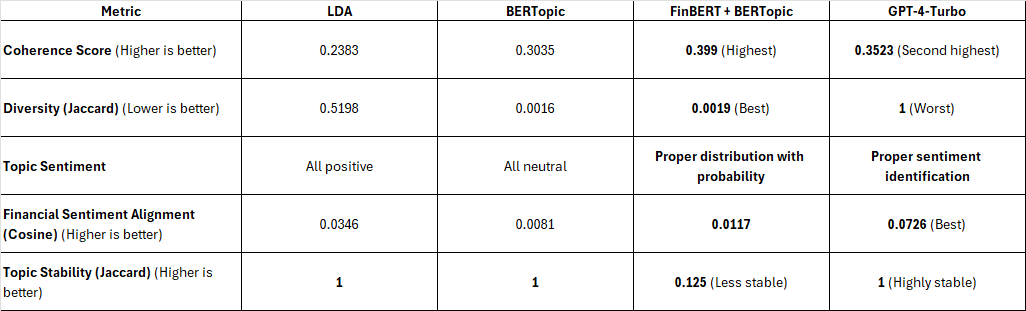

Final Recommendtation

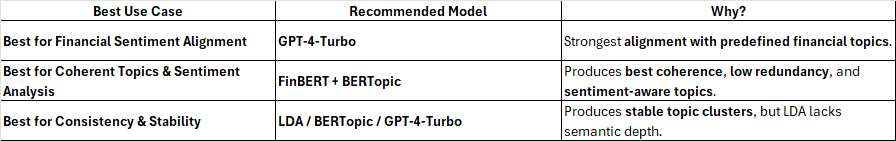

############################################
# Topic Modeling Using GPT-4-Turbo on Financial Text
############################################
#
# This script processes financial text data from CSV files using GPT-4-Turbo to identify topics discussed in the text.
# It follows these steps:
#
# Step 1: Load the input CSV file into a pandas DataFrame.
# Step 2: Define a function to interact with OpenAI GPT-4-Turbo to extract topics and their descriptions.
# Step 3: Apply this function to the 'Question_cleand' column to create topic-related columns.
# Step 4: Apply the same function to the 'Response_cleand' column.
# Step 5: Save the final DataFrame to a CSV file.
#
# Required Libraries:
# - openai: For interacting with GPT-4-Turbo.
# - pandas: For handling data operations.
# - os: For managing environment variables.
############################################

In [ ]:
# Install required libraries (if not already installed)
!pip install -q openai==0.28
!pip install -q pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.1 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import openai
import pandas as pd
import os
import re

# Ensure OpenAI API key is set
openai_api_key = os.getenv("Openai_key")


In [ ]:
############################################
# Step 1: Load CSV Files into DataFrame
############################################

# Load the CSV file (assuming the user uploads it)
input_df = pd.read_csv("/content/ubs_qa_df_preprocessed_ver2.csv")
print("CSV file loaded successfully.")

CSV file loaded successfully.


In [ ]:
input_df

,filename,Quarter,Question,Question_cleaned,Analyst_Bank,Response,Response_cleaned,Executive
0,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti']
1,1q23-earnings-call-remarks.pdf,1Q23,Yeah. Thanks. Just two questions. The first on...,['so sarah take first question take secondso g...,JPMorgan,"So, Sarah, take the first question. I'll take ...",['yeah thanks two questions first one related ...,"['Sergio P. Ermotti', 'Sarah Youngwood']"
2,1q23-earnings-call-remarks.pdf,1Q23,"Yeah. Thank you. Good morning. Welcome back, S...",['thank you ryan good back interact well look ...,Bank of America,"Thank you, Ryan. It is good to be back to inte...",['yeah thank you good morning welcome back ser...,['Sergio P. Ermotti']
3,1q23-earnings-call-remarks.pdf,1Q23,Yes. Good morning. The first question I wanted...,['so first question terms trends april really ...,Jefferies,"So, on the first question in terms of the tren...",['yes good morning first question wanted ask r...,"['Sergio P. Ermotti', 'Sarah Youngwood']"
4,1q23-earnings-call-remarks.pdf,1Q23,"Good morning. Two questions. Firstly, just on ...",['so first quarter first question seen signifi...,Citi,"So, on the first quarter or the first question...",['good morning two questions firstly slide 10 ...,['Sarah Youngwood']
...,...,...,...,...,...,...,...,...
91,4q24-earnings-call-remarks.pdf,4Q24,Good morning. One follow-up on GWM Americas an...,['first first question respect fa comp changes...,Citi,"So first, on your first question in respect to...",['good morning one follow-up gwm americas perh...,['Todd Tuckner']
92,4q24-earnings-call-remarks.pdf,4Q24,Very helpful. Thank you very much.,[''],Autonomous Research,NaN,['helpful thank much'],[]
93,4q24-earnings-call-remarks.pdf,4Q24,Hi. Thank you and thank you for the clarificat...,['yeah terms expectations really articulated s...,Mediobanca,"Yeah. So in terms of the expectations, we have...",['hi thank thank clarifications capital got co...,['Todd Tuckner']
94,4q24-earnings-call-remarks.pdf,4Q24,Good morning. It's Antonio from Bank of Americ...,['terms mitigants bit headwinds know definitel...,Bank of America,So in terms of the mitigants a bit to the head...,['good morning antonio bank america two questi...,['Todd Tuckner']


In [ ]:
############################################
# Step 2: Define Function to Extract Topics using GPT-4-Turbo
############################################
print("Defining GPT-4-Turbo function for topic extraction...")

def extract_topics(text):
    """
    This function takes a financial text input and analyzes the topics discussed in the text.
    It returns a list of topics and corresponding sentences that contributed to each topic.
    """
    if pd.isna(text) or text.strip() == "":
        return "No Topic", "No Relevant Sentences"

    prompt = f"""
    Analyze the following financial text and extract distinct topics discussed.
    Provide:
    1. The topic names.
    2. Example sentences that helped you identify the topic.

    Text:
    {text}
    """

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4-turbo",
            messages=[{"role": "user", "content": prompt}]
        )

        result = response["choices"][0]["message"]["content"]

        # Splitting response into topic and description
        if "\n" in result:
            parts = result.split("\n", 1)
            topic = parts[0].strip()
            topic_description = parts[1].strip()
        else:
            topic = result.strip()
            topic_description = "Description not available"

        return topic, topic_description
    except Exception as e:
        return "Error", str(e)

Defining GPT-4-Turbo function for topic extraction...


In [ ]:
############################################
# Step 3: Apply Function to 'Question_cleand' Column
############################################

input_df[['Question_topic', 'Question_topic_description']] = input_df['Question_cleaned'].apply(
    lambda x: pd.Series(extract_topics(x))
)

question_df = input_df.copy()
print("Topic extraction for questions completed.")

Topic extraction for questions completed.


In [ ]:
question_df

,filename,Quarter,Question,Question_cleaned,Analyst_Bank,Response,Response_cleaned,Executive,Question_topic,Question_topic_description
0,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...
1,1q23-earnings-call-remarks.pdf,1Q23,Yeah. Thanks. Just two questions. The first on...,['so sarah take first question take secondso g...,JPMorgan,"So, Sarah, take the first question. I'll take ...",['yeah thanks two questions first one related ...,"['Sergio P. Ermotti', 'Sarah Youngwood']",The provided financial text discusses multiple...,1. **Economic Impact Analysis**\n - Example ...
2,1q23-earnings-call-remarks.pdf,1Q23,"Yeah. Thank you. Good morning. Welcome back, S...",['thank you ryan good back interact well look ...,Bank of America,"Thank you, Ryan. It is good to be back to inte...",['yeah thank you good morning welcome back ser...,['Sergio P. Ermotti'],"Based on the text provided, several distinct t...",1. **Topic Name: Asset Management and Restruct...
3,1q23-earnings-call-remarks.pdf,1Q23,Yes. Good morning. The first question I wanted...,['so first question terms trends april really ...,Jefferies,"So, on the first question in terms of the tren...",['yes good morning first question wanted ask r...,"['Sergio P. Ermotti', 'Sarah Youngwood']",The financial text provided discusses several ...,1. **Regional Strengths and Complementarity in...
4,1q23-earnings-call-remarks.pdf,1Q23,"Good morning. Two questions. Firstly, just on ...",['so first quarter first question seen signifi...,Citi,"So, on the first quarter or the first question...",['good morning two questions firstly slide 10 ...,['Sarah Youngwood'],"From the provided financial text, several dist...",1. **Mix Shifts in Financial Systems**\n - *...
...,...,...,...,...,...,...,...,...,...,...
91,4q24-earnings-call-remarks.pdf,4Q24,Good morning. One follow-up on GWM Americas an...,['first first question respect fa comp changes...,Citi,"So first, on your first question in respect to...",['good morning one follow-up gwm americas perh...,['Todd Tuckner'],"From the provided financial text, the followin...",1. **Compensation and Strategy Alignment**\n ...
92,4q24-earnings-call-remarks.pdf,4Q24,Very helpful. Thank you very much.,[''],Autonomous Research,NaN,['helpful thank much'],[],"It appears that the provided text is empty, as...",Description not available
93,4q24-earnings-call-remarks.pdf,4Q24,Hi. Thank you and thank you for the clarificat...,['yeah terms expectations really articulated s...,Mediobanca,"Yeah. So in terms of the expectations, we have...",['hi thank thank clarifications capital got co...,['Todd Tuckner'],"Based on the provided financial text, I have i...",1. **Financial Expectations and Goals**:\n -...
94,4q24-earnings-call-remarks.pdf,4Q24,Good morning. It's Antonio from Bank of Americ...,['terms mitigants bit headwinds know definitel...,Bank of America,So in terms of the mitigants a bit to the head...,['good morning antonio bank america two questi...,['Todd Tuckner'],From the provided text which seems to be part ...,1. **Revenue Growth and Hedging Strategies**\n...


In [ ]:
############################################
# Step 4: Apply Function to 'Response_cleand' Column
############################################
print("Applying GPT-4-Turbo function on 'Response_cleand' column...")

question_df[['Answer_topic', 'Answer_topic_description']] = question_df['Response_cleaned'].apply(
    lambda x: pd.Series(extract_topics(x))
)

final_df = question_df.copy()
print("Topic extraction for responses completed.")

Applying GPT-4-Turbo function on 'Response_cleand' column...
Topic extraction for responses completed.


In [ ]:
final_df

,filename,Quarter,Question,Question_cleaned,Analyst_Bank,Response,Response_cleaned,Executive,Question_topic,Question_topic_description,Answer_topic,Answer_topic_description
0,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,### 1. Topics discussed in the text:,**Topic 1: Capital Requirements and Regulatory...
1,1q23-earnings-call-remarks.pdf,1Q23,Yeah. Thanks. Just two questions. The first on...,['so sarah take first question take secondso g...,JPMorgan,"So, Sarah, take the first question. I'll take ...",['yeah thanks two questions first one related ...,"['Sergio P. Ermotti', 'Sarah Youngwood']",The provided financial text discusses multiple...,1. **Economic Impact Analysis**\n - Example ...,Based on the analysis of the provided financia...,1. **Book Value Per Share Guidance:**\n - Ex...
2,1q23-earnings-call-remarks.pdf,1Q23,"Yeah. Thank you. Good morning. Welcome back, S...",['thank you ryan good back interact well look ...,Bank of America,"Thank you, Ryan. It is good to be back to inte...",['yeah thank you good morning welcome back ser...,['Sergio P. Ermotti'],"Based on the text provided, several distinct t...",1. **Topic Name: Asset Management and Restruct...,"Based on the text provided, here are the topic...",1. **Merger and Acquisition Strategy**\n - *...
3,1q23-earnings-call-remarks.pdf,1Q23,Yes. Good morning. The first question I wanted...,['so first question terms trends april really ...,Jefferies,"So, on the first question in terms of the tren...",['yes good morning first question wanted ask r...,"['Sergio P. Ermotti', 'Sarah Youngwood']",The financial text provided discusses several ...,1. **Regional Strengths and Complementarity in...,"Based on the given financial text, several dis...","1. **Net New Money Trends**\n - _""first ques..."
4,1q23-earnings-call-remarks.pdf,1Q23,"Good morning. Two questions. Firstly, just on ...",['so first quarter first question seen signifi...,Citi,"So, on the first quarter or the first question...",['good morning two questions firstly slide 10 ...,['Sarah Youngwood'],"From the provided financial text, several dist...",1. **Mix Shifts in Financial Systems**\n - *...,The text involves a financial discussion focus...,1. **Net Interest Income (NII) Forecast and Ra...
...,...,...,...,...,...,...,...,...,...,...,...,...
91,4q24-earnings-call-remarks.pdf,4Q24,Good morning. One follow-up on GWM Americas an...,['first first question respect fa comp changes...,Citi,"So first, on your first question in respect to...",['good morning one follow-up gwm americas perh...,['Todd Tuckner'],"From the provided financial text, the followin...",1. **Compensation and Strategy Alignment**\n ...,"From the provided text, the following distinct...",1. **Strategic Changes and Incentives in GWM A...
92,4q24-earnings-call-remarks.pdf,4Q24,Very helpful. Thank you very much.,[''],Autonomous Research,NaN,['helpful thank much'],[],"It appears that the provided text is empty, as...",Description not available,"Based on the provided text ""helpful thank much...",1. **Customer Service or Support**\n - Examp...
93,4q24-earnings-call-remarks.pdf,4Q24,Hi. Thank you and thank you for the clarificat...,['yeah terms expectations really articulated s...,Mediobanca,"Yeah. So in terms of the expectations, we have...",['hi thank thank clarifications capital got co...,['Todd Tuckner'],"Based on the provided financial text, I have i...",1. **Financial Expectations and Goals**:\n -...,"Upon analyzing the provided text, distinct top...",1. **Future Profitability Goals:**\n - **Top...
94,4q24-earnings-call-remarks.pdf,4Q24,Good morning. It's Antonio from Bank of Americ...,['terms mitigants bit headwinds know definitel...,Bank of Am

In [ ]:
############################################
# Step 5: Save Final DataFrame to CSV
############################################
print("Saving final DataFrame to CSV...")

final_df.to_csv("tqc_topic_model_jpmorgan.csv", index=False)
print("CSV file saved successfully.")

Saving final DataFrame to CSV...
CSV file saved successfully.


In [ ]:
# Function to split topics and expand rows
def split_topics(row):
    topics = re.split(r'\n?\d+\.\s\*\*(.*?)\*\*:', row['Answer_topic_description'])
    topics = [t.strip() for t in topics if t.strip()]  # Remove empty entries
    return pd.DataFrame([{**row, 'Answer_topic_description': t} for t in topics])

# Apply the function to each row and reset the index
expanded_df = pd.concat([split_topics(row) for _, row in final_df.iterrows()], ignore_index=True)

# Display the processed DataFrame
expanded_df

,Quarter,Question,Question_cleaned,Analyst,Analyst Role,Response,Response_cleaned,Executive,Executive Role Type,Question_topic,Question_topic_description,Answer_topic,Answer_topic_description
0,4Q24,"Hi. Good morning. Jeremy, I wanted to ask abou...",['hi good morning jeremy wanted ask capital kn...,John McDonald,"Analyst, Truist Securities, Inc.","Yeah. Good question, John, and welcome back, b...",['yeah good question john welcome back way so ...,Jeremy Barnum,CFO,"Based on the provided text, here are the disti...",1. **Capital Management:**\n - Example sente...,"Based on the provided financial text, the foll...",Strategic Financial Decisions & Capital Alloca...
1,4Q24,"Hi. Good morning. Jeremy, I wanted to ask abou...",['hi good morning jeremy wanted ask capital kn...,John McDonald,"Analyst, Truist Securities, Inc.","Yeah. Good question, John, and welcome back, b...",['yeah good question john welcome back way so ...,Jeremy Barnum,CFO,"Based on the provided text, here are the disti...",1. **Capital Management:**\n - Example sente...,"Based on the provided financial text, the foll...",- This topic is identified through the discuss...
2,4Q24,"Hi. Good morning. Jeremy, I wanted to ask abou...",['hi good morning jeremy wanted ask capital kn...,John McDonald,"Analyst, Truist Securities, Inc.","Yeah. Good question, John, and welcome back, b...",['yeah good question john welcome back way so ...,Jeremy Barnum,CFO,"Based on the provided text, here are the disti...",1. **Capital Management:**\n - Example sente...,"Based on the provided financial text, the foll...",Investment Strategy and Focus Areas
3,4Q24,"Hi. Good morning. Jeremy, I wanted to ask abou...",['hi good morning jeremy wanted ask capital kn...,John McDonald,"Analyst, Truist Securities, Inc.","Yeah. Good question, John, and welcome back, b...",['yeah good question john welcome back way so ...,Jeremy Barnum,CFO,"Based on the provided text, here are the disti...",1. **Capital Management:**\n - Example sente...,"Based on the provided financial text, the foll...",- The focus is on high-certainty investment ch...
4,4Q24,"Hi. Good morning. Jeremy, I wanted to ask abou...",['hi good morning jeremy wanted ask capital kn...,John McDonald,"Analyst, Truist Securities, Inc.","Yeah. Good question, John, and welcome back, b...",['yeah good question john welcome back way so ...,Jeremy Barnum,CFO,"Based on the provided text, here are the disti...",1. **Capital Management:**\n - Example sente...,"Based on the provided financial text, the foll...",Operating Efficiency and Cost Management
...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,1Q23,Thank you. So you talked about in your letter ...,['thank you talked letter regulators avoiding ...,Glenn Schorr,"Analyst, Evercore ISI",NaN,['nan'],Jeremy Barnum,CFO & Co.,"Based on the analysis of the provided text, th...",1. **Customer and Corporate Response to Financ...,Based on the provided text which contains only...,Unavailable or Missing Data
207,1Q23,Thank you. So you talked about in your letter ...,['thank you talked letter regulators avoiding ...,Glenn Schorr,"Analyst, Evercore ISI",NaN,['nan'],Jeremy Barnum,CFO & Co.,"Based on the analysis of the provided text, th...",1. **Customer and Corporate Response to Financ...,Based on the provided text which contains only...,Example Sentence
208,1Q23,Thank you. So you talked about in your letter ...,['thank you talked letter regulators avoiding ...,Glenn Schorr,"Analyst, Evercore ISI",NaN,['nan'],Jeremy Barnum,CFO & Co.,"Based on the analysis of the provided text, th...",1. **Customer and Corporate Response to Financ...,Based on the provided text which contains only...,"In the entire input text, the only element ava..."
209,1Q23,Good morning. You guys talked about one of the...,['good morning guys talked one drivers higher ...,Matt O'Connor,"Analyst, Deutsche Bank Securities, Inc.",NaN,['nan'],Jeremy Barnum,CFO & Co.,"Based on the provided financial text, there ar...",1. **Net Interest Incom

In [ ]:
# Function to extract topics and reformat the row
def extract_topics(row):
    # Splitting based on numbered pattern (1, 2, 3, etc.) while keeping the content
    sections = re.split(r'\n?\d+\.\s', row['Answer_topic_description'])
    sections = [s.strip() for s in sections if s.strip()]  # Remove empty entries

    # Create a new dictionary for the reformatted row
    new_row = row.to_dict()

    # Assign each section to a new numbered column
    for i, section in enumerate(sections):
        new_row[f"Topic_{i+1}"] = section  # Naming columns as Topic_1, Topic_2, etc.

    return new_row

# Apply the function and expand the DataFrame
expanded_df = pd.DataFrame([extract_topics(row) for _, row in final_df.iterrows()])

# Display the processed DataFrame
expanded_df

,Quarter,Question,Question_cleaned,Analyst,Analyst Role,Response,Response_cleaned,Executive,Executive Role Type,Question_topic,...,Answer_topic_description,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,4Q24,"Hi. Good morning. Jeremy, I wanted to ask abou...",['hi good morning jeremy wanted ask capital kn...,John McDonald,"Analyst, Truist Securities, Inc.","Yeah. Good question, John, and welcome back, b...",['yeah good question john welcome back way so ...,Jeremy Barnum,CFO,"Based on the provided text, here are the disti...",...,1. **Strategic Financial Decisions & Capital A...,**Strategic Financial Decisions & Capital Allo...,**Investment Strategy and Focus Areas**:\n -...,**Operating Efficiency and Cost Management**:\...,**Technological Modernization and Efficiency**...,**Headcount Management and Organizational Effi...,**Critical Risk Management and Safety**:\n -...,NaN,NaN,NaN
1,4Q24,"Hi. Simple and then more difficult, I guess. J...",['hi simple difficult guess jamie whos success...,Mike Mayo,"Analyst, Wells Fargo Securities LLC",I do love what I do. And answering the second ...,['love do answering second question first look...,Jamie Dimon,CEO,"Based on the provided text, three distinct top...",...,1. **Succession Planning**: \n - Example Sen...,**Succession Planning**: \n - Example Senten...,**Health Concerns and Rational Decisions**:\n ...,**Public Perception and Media Interaction**:\n...,**Talent Review and Internal Decision Making**...,**Uncertainty and Flexibility in Plans**:\n ...,**Leadership Continuity and Company Stability*...,NaN,NaN,NaN
2,4Q24,"Hey. Good morning. Maybe just on regulation, w...",['hey good morning maybe regulation new admini...,Jim Mitchell,"Analyst, Seaport Global Securities LLC","Hey, Jim. I mean, it's obviously something we'...",['hey jim mean obviously something thinking lo...,Jeremy Barnum,CFO,"From the provided text, it seems to discuss to...",...,"- Example Sentence: ""we want a coherent, ratio...","- Example Sentence: ""we want a coherent, ratio...",Topic Name: **Bank's Role and Operations**\n ...,Topic Name: **Challenges to Bank Efficiency**\...,Topic Name: **Capital Management and Basel III...,Topic Name: **Business Sentiment and Loan Grow...,Topic Name: **Market Conditions and Business B...,Topic Name: **Economic Optimism and its Realiz...,NaN,NaN
3,4Q24,"Yes. Hi, good morning. Wanted to follow up on ...",['yes hi good morning wanted follow questions ...,Erika Najarian,"Analyst, UBS Securities LLC","Right, Erika. Okay. You are tempting me with m...",['right erika okay tempting many rabbit holes ...,Jeremy Barnum,CFO,1. **Topic Name: Capital Requirements and Regu...,...,1. **Seasonality and G-SIB Metrics**\n - **E...,**Seasonality and G-SIB Metrics**\n - **Exam...,**Regulatory Reviews and Amendments**\n - **...,**Legal Actions and Industry Response**\n - ...,**Capital Requirements and Economic Growth**\n...,**Scenario Analysis and Capital Projections**\...,NaN,NaN,NaN,NaN
4,4Q24,"Does that conclude your question, Erika?",['conclude question erika'],Erika,Unknown,Very good. We can go to the next question. Tha...,['good go next question thanks yeah'],Jeremy Barnum,CFO,"Based on the given text: ""conclude question er...",...,1. **General Conversation Closure or Transitio...,**General Conversation Closure or Transition**...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1Q23,"Hey Jeremy, you mentioned a degree of reinterm...",['hey jeremy mentioned degree reintermediation...,Mike Mayo,"Analyst, Wells Fargo Securities LLC",NaN,['nan'],Jamie Dimon,CEO & Co.,1. **Reintermediation in Lending Markets**,...,Description not available,Description not available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,1Q23,Hi. Good morning.\nI do want to unpack the que...,['hi good morning want unpack question possibi...,Betsy L. Graseck,"Analyst, Morgan Stanley & Co. LLC",NaN,['nan'],Jeremy Barnum,CFO & Co.,"Analyzing t

In [ ]:
############################################
# Step 6: Save Final DataFrame to CSV
############################################
print("Saving final DataFrame to CSV...")

final_df.to_csv("tqc_topic_model_jpmorgan_breakdown.csv", index=False)
print("CSV file saved successfully.")

Saving final DataFrame to CSV...
CSV file saved successfully.


In [ ]:
# Creating DataFrame
df = pd.DataFrame(final_df)

# Function to explode Topic column
def explode_topics(df):
    df = df.copy()
    df["Answer_topic_description"] = df["Answer_topic_description"].str.split(r'\s\d+\. ')
    df["Answer_topic_description"] = df["Answer_topic_description"].apply(lambda x: [i for i in x if i])
    return df.explode("Answer_topic_description", ignore_index=True)

# Applying function
df_exploded = explode_topics(df)

# Displaying the result
df_exploded

,filename,Quarter,Question,Question_cleaned,Analyst_Bank,Response,Response_cleaned,Executive,Question_topic,Question_topic_description,Answer_topic,Answer_topic_description
0,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,### 1. Topics discussed in the text:,**Topic 1: Capital Requirements and Regulatory...
1,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,### 1. Topics discussed in the text:,Additional Details from the Text:\n\nThe text ...
2,1q23-earnings-call-remarks.pdf,1Q23,Yeah. Thanks. Just two questions. The first on...,['so sarah take first question take secondso g...,JPMorgan,"So, Sarah, take the first question. I'll take ...",['yeah thanks two questions first one related ...,"['Sergio P. Ermotti', 'Sarah Youngwood']",The provided financial text discusses multiple...,1. **Economic Impact Analysis**\n - Example ...,Based on the analysis of the provided financia...,1. **Book Value Per Share Guidance:**\n - Ex...
3,1q23-earnings-call-remarks.pdf,1Q23,Yeah. Thanks. Just two questions. The first on...,['so sarah take first question take secondso g...,JPMorgan,"So, Sarah, take the first question. I'll take ...",['yeah thanks two questions first one related ...,"['Sergio P. Ermotti', 'Sarah Youngwood']",The provided financial text discusses multiple...,1. **Economic Impact Analysis**\n - Example ...,Based on the analysis of the provided financia...,**Client Retention and Impact on Wealth Manage...
4,1q23-earnings-call-remarks.pdf,1Q23,"Yeah. Thank you. Good morning. Welcome back, S...",['thank you ryan good back interact well look ...,Bank of America,"Thank you, Ryan. It is good to be back to inte...",['yeah thank you good morning welcome back ser...,['Sergio P. Ermotti'],"Based on the text provided, several distinct t...",1. **Topic Name: Asset Management and Restruct...,"Based on the text provided, here are the topic...",1. **Merger and Acquisition Strategy**\n - *...
...,...,...,...,...,...,...,...,...,...,...,...,...
276,4q24-earnings-call-remarks.pdf,4Q24,Good morning. It's Antonio from Bank of Americ...,['terms mitigants bit headwinds know definitel...,Bank of America,So in terms of the mitigants a bit to the head...,['good morning antonio bank america two questi...,['Todd Tuckner'],From the provided text which seems to be part ...,1. **Revenue Growth and Hedging Strategies**\n...,The analyzed financial text discusses two main...,**NII Sensitivity and Hedging in Banking**\n ...
277,4q24-earnings-call-remarks.pdf,4Q24,"Yes, good morning, everybody. I just got two f...",['hi piers – take second question first terms ...,HSBC,"Hi Piers, so on – I'll just take your second q...",['yes good morning everybody got two follow-up...,"['Todd Tuckner', 'Sergio P. Ermotti']","Based on the provided text, the conversation a...",1. **Basel III Impact and Internal Management*...,"Based on the provided financial text, here are...",1. **Client Risk Appetite and Banking Activity...
278,4q24-earnings-call-remarks.pdf,4Q24,"Yes, good morning, everybody. I just got two f...",['hi piers – take second question first terms ...,HSBC,"Hi Piers, so on – I'll just take your second q...",['yes good morning everybody got two follow-up...,"['Todd Tuckner', 'Sergio P. Ermotti']","Based on the provided text, the conversation a...",1. **Basel III Impact and Internal Management*...,"Based on the provided financial text, here are...",**Loan 

In [ ]:
df_exploded.to_csv("tqc_topic_model_ubs_breakdown1.csv", index=False)
print("CSV file saved successfully.")

CSV file saved successfully.


**Objective:**

The topics extracted are micro level topics. These are goods for sentiment analysis but not aligned with summarization model. So, the risk of the topic along with the high level topics are also determined after sentiment run.

**Approach:**

The following parameters are added.

Marco level topics: These are G-SIB assesment criteria. The micro level topics classified through key words of these topics.

High Level topics: These are key topics of any financial institutions. For example, asset, liiability, profit, loos etc.

Risk: The micro topics may be risky such as credit score. The topics are classified into 3 risk categories. These are High, medium and Low.

**Process:**

The GPT-4-Turbo model prompted with role 'Financial Analyst' to perform the above classification based on micro topics.

# Section 1: Loading the data

In [ ]:
import pandas as pd

# Replace 'your_file.csv' with the actual file path
file_path = "/content/UBS_questions_sent_output_050325_v1.csv"

# Read the CSV file into a DataFrame
input_df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
input_df.head()

,filename,Quarter,Question,Question_cleaned,Analyst_Bank,Response,Response_cleaned,Executive,Question_topic,Question_topic_description,Topic,Snippet,snippet_sent
0,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Capital Requirements,okay thank you capital requirements know situa...,Neutral
1,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Business Scope and Exit,determine scope perimeter activities run parti...,Neutral
2,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Operational Risk,will course impact op-risk capital charges on,Neutral
3,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Communication and Clarity,clarity aspects communicate expect something s...,Neutral
4,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Transaction and Value,merits value accretion creation transaction re...,Neutral


In [ ]:
!pip install -q openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.5 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import openai
import pandas as pd
import os
import re

# Ensure OpenAI API key is set
openai_api_key = os.getenv("Openai_key")

# Section 2: Classification of risk

In [ ]:
# Function to classify risk using GPT-4-Turbo
def classify_risk(snippet):
    prompt = f"""You are a financial risk assessment model.
    Analyze the following financial snippet and classify the risk level as High, Medium, or Low.
    Only return one of these three words: High, Medium, or Low.

    Financial Snippet: "{snippet}"

    Risk Level:"""

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4-turbo",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=10
        )
        return response["choices"][0]["message"]["content"].strip()
    except Exception as e:
        print(f"Error processing snippet: {e}")
        return "Unknown"


In [ ]:
# Apply function to classify risk
input_df["Risk"] = input_df["Snippet"].astype(str).apply(classify_risk)

# Display first few rows of the updated DataFrame
input_df.head()

,filename,Quarter,Question,Question_cleaned,Analyst_Bank,Response,Response_cleaned,Executive,Question_topic,Question_topic_description,Topic,Snippet,snippet_sent,Risk
0,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Capital Requirements,okay thank you capital requirements know situa...,Neutral,Low
1,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Business Scope and Exit,determine scope perimeter activities run parti...,Neutral,High
2,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Operational Risk,will course impact op-risk capital charges on,Neutral,High
3,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Communication and Clarity,clarity aspects communicate expect something s...,Neutral,High
4,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Transaction and Value,merits value accretion creation transaction re...,Neutral,High


# Section 3: Classification according to G-SIB crieria

In [ ]:
# Define the topics and associated keywords
topics_keywords = {
    "Cross-jurisdictional claims": "foreign claims, international claims, cross-border claims, local claims in foreign currency, BIS consolidated banking statistics",
    "Cross-jurisdictional liabilities": "foreign liabilities, related offices, BIS consolidated banking statistics, international banking market, local liabilities in local currency",
    "Total exposure": "total assets, total liabilities, risk-weighted assets, leverage ratio, Basel III, capital adequacy, bank exposures",
    "Intra-financial system assets": "lending to financial institutions, securities holdings, reverse repurchase agreements, securities lending, OTC derivatives assets",
    "Intra-financial system liabilities": "deposits by financial institutions, securities issued, repurchase agreements, securities borrowing, OTC derivatives liabilities",
    "Wholesale funding ratio": "wholesale funding, total liabilities, retail deposits, certificates of deposit, debt securities, interbank market",
    "Assets under custody": "custodian bank, financial market infrastructures, institutional investors, asset servicing, fund administration",
    "Payments cleared and settled through payment systems": "payment processing, clearing house, liquidity providers, financial transactions, central counterparties, real-time gross settlement (RTGS)",
    "Values of underwritten transactions in debt and equity markets": "debt issuance, equity issuance, underwriting, primary markets, syndicated loans, investment banking",
    "OTC derivatives notional value": "over-the-counter derivatives, financial contracts, notional value, swaps, options, forwards, derivatives market",
    "Trading book and available-for-sale securities": "financial securities, trading book, mark-to-market, investment portfolios, bond markets, equity markets"
}

In [ ]:
# Function to classify a snippet into a macro topic
def classify_topic(snippet):
    prompt = f"""
    You are a financial classification assistant. Analyze the following financial snippet and classify it into one of the predefined topics.
    Here are the topics and their defining keywords:

    {topics_keywords}

    Financial Snippet: "{snippet}"

    Return ONLY the topic name from the list.
    """

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4-turbo",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=1000
        )
        return response["choices"][0]["message"]["content"].strip()
    except Exception as e:
        print(f"Error processing snippet: {e}")
        return "Total exposure"

In [ ]:
# Apply function to classify Macro Topics
input_df["Macro Topic"] = input_df["Snippet"].astype(str).apply(classify_topic)

# Display first few rows of the updated DataFrame
input_df.head()

,filename,Quarter,Question,Question_cleaned,Analyst_Bank,Response,Response_cleaned,Executive,Question_topic,Question_topic_description,Topic,Snippet,snippet_sent,Risk,Macro Topic
0,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Capital Requirements,okay thank you capital requirements know situa...,Neutral,Low,Total exposure
1,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Business Scope and Exit,determine scope perimeter activities run parti...,Neutral,High,'Cross-jurisdictional claims'
2,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Operational Risk,will course impact op-risk capital charges on,Neutral,High,Total exposure
3,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Communication and Clarity,clarity aspects communicate expect something s...,Neutral,High,This financial snippet does not relate directl...
4,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Transaction and Value,merits value accretion creation transaction re...,Neutral,High,Values of underwritten transactions in debt an...


In [ ]:
# Save the updated DataFrame to a new CSV
output_file_path = "classified_macro_topics.csv"
input_df.to_csv(output_file_path, index=False)

In [ ]:
import pandas as pd

# Load your classified DataFrame
file_path = "classified_macro_topics.csv"
input_df = pd.read_csv(file_path)

# Function to clean the Macro Topic column
def clean_macro_topic(topic):
    # Remove unwanted characters
    cleaned_topic = topic.replace("'", "").replace('"', "").strip()

    # Check if it has more than 10 words
    if len(cleaned_topic.split()) > 10:
        return "Multi-Topic"

    return cleaned_topic

# Apply the cleaning function
input_df["Macro Topic"] = input_df["Macro Topic"].astype(str).apply(clean_macro_topic)


# Display first few rows of the updated DataFrame
input_df.head()

,filename,Quarter,Question,Question_cleaned,Analyst_Bank,Response,Response_cleaned,Executive,Question_topic,Question_topic_description,Topic,Snippet,snippet_sent,Risk,Macro Topic
0,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Capital Requirements,okay thank you capital requirements know situa...,Neutral,Low,Total exposure
1,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Business Scope and Exit,determine scope perimeter activities run parti...,Neutral,High,Cross-jurisdictional claims
2,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Operational Risk,will course impact op-risk capital charges on,Neutral,High,Total exposure
3,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Communication and Clarity,clarity aspects communicate expect something s...,Neutral,High,Multi-Topic
4,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Transaction and Value,merits value accretion creation transaction re...,Neutral,High,Values of underwritten transactions in debt an...


In [ ]:
# Save the updated DataFrame to a new CSV
output_file_path = "tqc_UBS_classified_macro_topics.csv"
input_df.to_csv(output_file_path, index=False)

# Section 4: Classification of High Level topics

In [ ]:
# Define the topics and associated keywords
topics_keywords = {
    "Revenue", "Cash", "Equity", "Liability", "Reserve", "Fixed Assets", "Receivables", "Payables", "Profit", "Loss"
}

In [ ]:
# Apply function to classify Macro Topics
input_df["High Level Topic"] = input_df["Snippet"].astype(str).apply(classify_topic)

# Display first few rows of the updated DataFrame
input_df.head()

,filename,Quarter,Question,Question_cleaned,Analyst_Bank,Response,Response_cleaned,Executive,Question_topic,Question_topic_description,Topic,Snippet,snippet_sent,Risk,Macro Topic,High Level Topic
0,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Capital Requirements,okay thank you capital requirements know situa...,Neutral,Low,Total exposure,Equity
1,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Business Scope and Exit,determine scope perimeter activities run parti...,Neutral,High,Cross-jurisdictional claims,Liability
2,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Operational Risk,will course impact op-risk capital charges on,Neutral,High,Total exposure,'Reserve'
3,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Communication and Clarity,clarity aspects communicate expect something s...,Neutral,High,Multi-Topic,Loss
4,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Transaction and Value,merits value accretion creation transaction re...,Neutral,High,Values of underwritten transactions in debt an...,Equity


In [ ]:
# Function to clean the Macro Topic column
# Function to clean the Macro Topic column
def clean_macro_topic(topic):
    # Remove unwanted characters
    cleaned_topic = topic.replace("'", "").replace('"', "").strip()

    # Check if it has more than 10 words
    if len(cleaned_topic.split()) > 10:
        return "Multi-Topic"

    return cleaned_topic

# Apply the cleaning function
input_df["High Level Topic"] = input_df["High Level Topic"].astype(str).apply(clean_macro_topic)


# Display first few rows of the updated DataFrame
input_df.head()

,filename,Quarter,Question,Question_cleaned,Analyst_Bank,Response,Response_cleaned,Executive,Question_topic,Question_topic_description,Topic,Snippet,snippet_sent,Risk,Macro Topic,High Level Topic
0,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Capital Requirements,okay thank you capital requirements know situa...,Neutral,Low,Total exposure,Equity
1,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Business Scope and Exit,determine scope perimeter activities run parti...,Neutral,High,Cross-jurisdictional claims,Liability
2,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Operational Risk,will course impact op-risk capital charges on,Neutral,High,Total exposure,Reserve
3,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Communication and Clarity,clarity aspects communicate expect something s...,Neutral,High,Multi-Topic,Loss
4,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Transaction and Value,merits value accretion creation transaction re...,Neutral,High,Values of underwritten transactions in debt an...,Equity


In [ ]:
# Save the updated DataFrame to a new CSV
output_file_path = "tqc_ubs_classified_highlevel_topics.csv"
input_df.to_csv(output_file_path, index=False)

Objective: To perform topic clustering on JPMorgan and UBS bank's Question & Answer data set.

Context: Based on the question and answer text of both the bank, Micro topis, Macro topics which are contextual to G-SIB assessment criteria, Risk of the topic posses and High level topics like asset or liability determined.

In this notebook, The Topic Clustering will be performed.

Approcah:

1. Dendrogram to visulaize possible topic clustering in the data
2. Quarter-Year wise heat map to check topic concentration
3. BERTopic based on 5 parameters. These are High level topic, Macro topic, Risk, Analyst and Micro Topic.
4. Intertopic distant map to visualize the micro topics on a hyper-plane combining all the above parameters.

# Section 1: Install Packages & Libraries

In [ ]:
!pip install -q bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import pdist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bertopic import BERTopic
import umap
import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import seaborn as sns

In [ ]:
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Section 2: Load dataframe

In [ ]:
# Load your dataset
final_df = pd.read_csv("/content/tqc_topic_cluster.csv")

# Section 3: Dendrogram

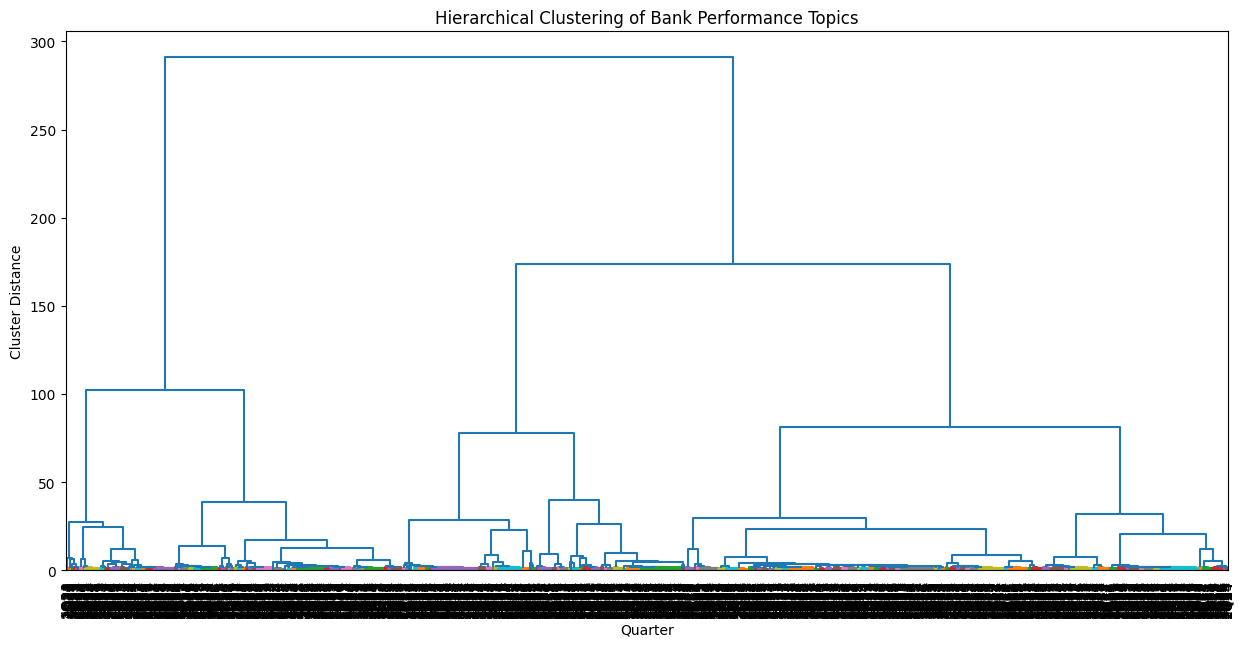

In [ ]:
# Encode categorical variables (Macro Topic, High Level Topic, Topic)
label_enc = LabelEncoder()
final_df["Macro_Topic_Enc"] = label_enc.fit_transform(final_df["Macro Topic"])
final_df["High_Level_Topic_Enc"] = label_enc.fit_transform(final_df["High Level Topic"])

# TF-IDF for 'Topic' column (micro-level topic embedding)
vectorizer = TfidfVectorizer()
topic_vectors = vectorizer.fit_transform(final_df["Topic"]).toarray()

# Combine features for clustering
feature_matrix = np.column_stack((final_df["Macro_Topic_Enc"],
                                  final_df["High_Level_Topic_Enc"],
                                  topic_vectors))

# Perform Hierarchical Clustering
linkage_matrix = linkage(feature_matrix, method='ward')

# Set figure size for visualization
plt.figure(figsize=(15, 7))

# Create color labels by 'Quarter' to distinguish groups in dendrogram
quarter_labels = final_df["Quarter"].astype("category").cat.codes  # Numeric encoding for color mapping

# Dendrogram visualization
dendrogram(linkage_matrix, labels=final_df["Quarter"].values,
           leaf_rotation=90, leaf_font_size=10,
           color_threshold=1.5*np.median(linkage_matrix[:, 2]))  # Adjust threshold for readability

plt.title("Hierarchical Clustering of Bank Performance Topics")
plt.xlabel("Quarter")
plt.ylabel("Cluster Distance")
plt.show()

Two Major Clusters at the Top:

There are two primary branches that merge at a very high cluster distance.
This suggests that bank performance topics fall into two broad categories.
Smaller Subclusters:

Within each of the major branches, we see multiple smaller clusters merging at lower distances.
This means that within each broad category, there are related groups of topics that are more closely related.

# Section 4: Clustering with Heat map

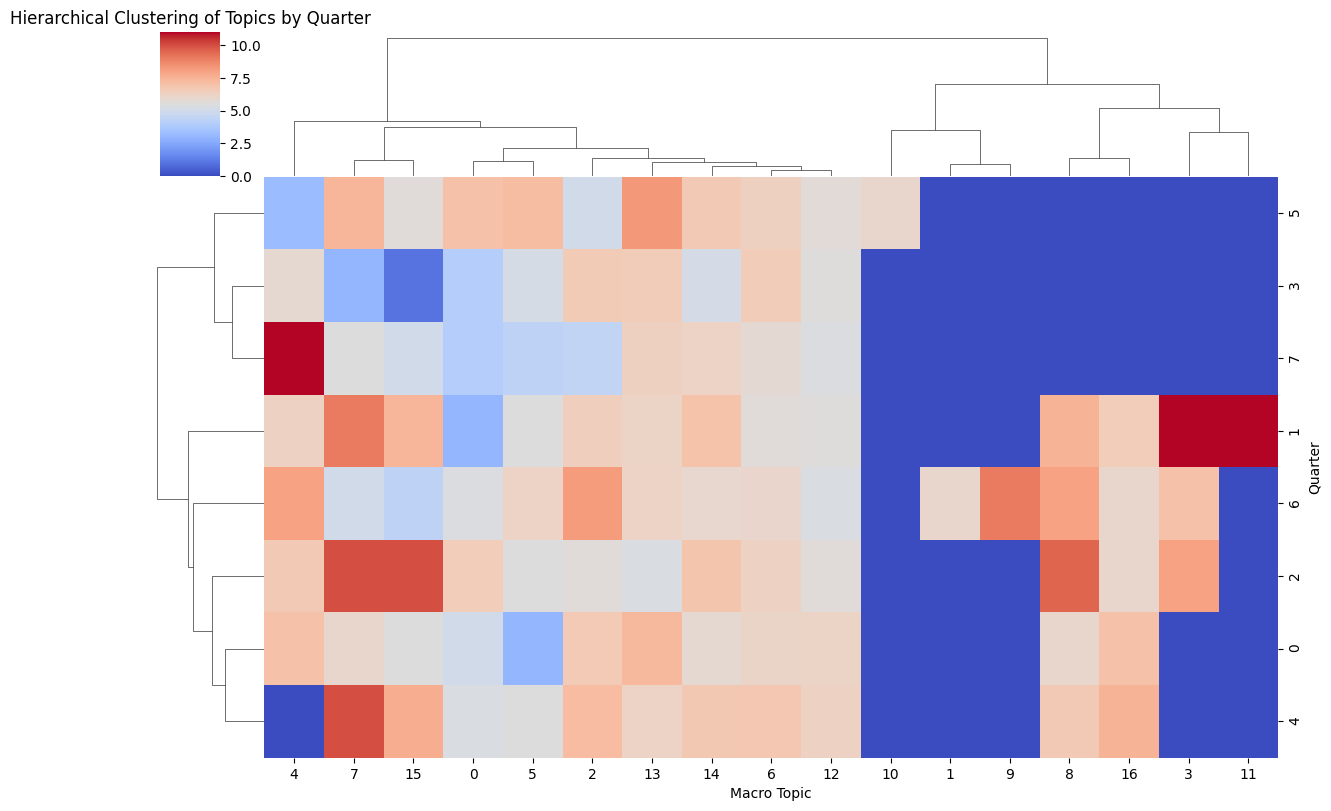

In [ ]:
# Encode categorical variables to numeric
label_encoders = {}
for col in ['Macro Topic', 'High Level Topic', 'Topic', 'Quarter']:
    le = LabelEncoder()
    final_df[col] = le.fit_transform(final_df[col])
    label_encoders[col] = le  # Store encoders for later inverse transform

# Compute distance matrix using categorical encodings
dist_matrix = squareform(pdist(final_df[['Macro Topic', 'High Level Topic', 'Topic']], metric='euclidean'))

# Perform hierarchical clustering
linkage_matrix = linkage(dist_matrix, method='ward')

# Assign clusters based on Macro Topic hierarchy
final_df['Cluster'] = fcluster(linkage_matrix, t=11, criterion='maxclust')  # 11 unique Macro Topics

# Create a pivot table for visualization
pivot_table = final_df.pivot_table(index='Quarter', columns='Macro Topic', values='Cluster', aggfunc='mean')

# Fill NaN values with 0 before clustering
pivot_table = pivot_table.fillna(0)  # Replace NaN with 0

# Create a clustermap for better visualization
sns.clustermap(pivot_table, method="ward", cmap="coolwarm", figsize=(12, 8), dendrogram_ratio=(0.1, 0.2))
plt.title("Hierarchical Clustering of Topics by Quarter")
plt.show()

Certain Quarters Form Similar Clusters:

The dendrogram on the left groups some quarters closely together.
This suggests that these quarters had similar banking discussions.
For example, Quarters 1 and 6 show similar topic distributions.
Macro Topics Also Cluster Together:

Some macro topics appear closely related (top dendrogram).
These topics may have been frequently discussed together.

# Section 5: Topic CLustering by BERTopic

In [ ]:
# Combine columns to create meaningful topic representations
# Ensure all columns are of string type before concatenation to avoid type errors
final_df["full_text"] = final_df["Macro Topic"].astype(str) + " " + final_df["High Level Topic"].astype(str) + " " + final_df["Topic"].astype(str)

# Step 1: Define UMAP and HDBSCAN parameters
umap_model = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 2: Create BERTopic Model
topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, verbose=True)

# Step 3: Fit the model on the combined textual column
topics, probs = topic_model.fit_transform(final_df["full_text"].values)

# Add topic assignments to DataFrame
final_df["Assigned_Topic"] = topics

# Step 4: Generate Topic Information
topic_info = topic_model.get_topic_info()

2025-03-08 18:14:56,526 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/52 [00:00<?, ?it/s]

2025-03-08 18:15:14,926 - BERTopic - Embedding - Completed ✓
2025-03-08 18:15:14,927 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-08 18:15:30,635 - BERTopic - Dimensionality - Completed ✓
2025-03-08 18:15:30,637 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-08 18:15:30,719 - BERTopic - Cluster - Completed ✓
2025-03-08 18:15:30,727 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-08 18:15:30,824 - BERTopic - Representation - Completed ✓


In [ ]:
# Step 5: Visualization - Topic Frequency Bar Chart
topic_model.visualize_barchart(top_n_topics=15)

Business explanation

If applied to G-SIB analysis:

Topics related to risk (e.g., Topic 4 & 10) may represent critical issues affecting banks' systemic importance.
Clustered words indicate specific areas of financial discussion, such as liquidity, capital, or credit risk.
If applied to sentiment analysis:

Topics with more distinct word scores may have stronger positive or negative sentiment trends.
Mapping these to snippet_sent (from your dataset) would help in tracking market sentiment per topic.

In [ ]:
# Step 6: Visualization - 2D UMAP Projection of Topics
fig = topic_model.visualize_topics()  # Returns a Plotly figure

# Display the interactive plot correctly
fig.show()


In [ ]:
# Step 7: Display topic descriptions
topic_model.get_topic_info().head(10)  # Show top 10 topics

,Topic,Count,Name,Representation,Representative_Docs
0,-1,276,-1_15_18_162_16,"[15, 18, 162, 16, 13, 343, 890, 262, 1456, 590]","[6 18 262, 12 3 162, 6 9 162]"
1,0,51,0_82_874_873_848,"[82, 874, 873, 848, 862, 828, 845, 898, 847, 891]","[12 6 82, 12 6 82, 12 6 82]"
2,1,39,1_957_955_954_940,"[957, 955, 954, 940, 943, 938, 93, 928, 923, 921]","[12 18 955, 12 19 957, 12 19 957]"
3,2,36,2_15_1000_428_426,"[15, 1000, 428, 426, 439, 418, 395, 369, 315, ...","[15 3 453, 15 9 369, 15 9 395]"
4,3,28,3_639_659_654_694,"[639, 659, 654, 694, 693, 687, 679, 676, 675, ...","[12 16 639, 12 16 639, 12 16 639]"
5,4,27,4_987_972_941_944,"[987, 972, 941, 944, 982, 978, 977, 976, 975, ...","[14 9 987, 14 6 987, 15 15 987]"
6,5,26,5_709_639_703_75,"[709, 639, 703, 75, 735, 734, 725, 724, 719, 716]","[12 20 639, 12 6 709, 12 20 709]"
7,6,25,6_425_292_333_328,"[425, 292, 333, 328, 327, 325, 319, 310, 309, ...","[13 7 213, 13 20 327, 13 18 257]"
8,7,20,7_1285_1283_1290_1286,"[1285, 1283, 1290, 1286, 1284, 167, 1282, 1281...","[12 20 1016, 12 20 1285, 12 20 1285]"
9,8,20,8_1166_1189_1187_1186,"[1166, 1189, 1187, 1186, 1185, 1184, 1183, 118...","[12 16 1127, 12 18 116, 12 18 1160]"


Summary of Hierarchical Clustering and BERTopic Analysis

1. Dendrogram Insights: Macro-Level Topic Clustering
The hierarchical dendrogram provides a structured view of how bank performance topics cluster over time. The two primary branches at the highest level indicate that macro topics can be grouped into two broad categories, likely reflecting fundamental differences in financial discussions, such as asset growth vs. risk exposure or profitability vs. liquidity concerns. The subclusters within each primary branch suggest that certain topics are more closely related, which means banks tend to discuss particular financial metrics together. The dense clustering at the bottom of the dendrogram indicates that many topics share similar discussion patterns, particularly within specific quarters.

Furthermore, the overlapping x-axis labels indicate that many unique quarters were analyzed, making it difficult to interpret at a glance.

By analyzing the cluster distances, we can infer that some macro topics exhibit high correlation over time, meaning banks consistently focus on them, while others emerge sporadically.

2. Heatmap Observations: Topic Distribution Over Time
The hierarchical heatmap offers a granular view of how macro topics evolved across quarters, showing which topics dominated certain periods and which remained stable over time. Red/orange clusters indicate high prevalence of a topic in a specific quarter, while blue regions suggest low engagement. The strong color differentiation in certain quarters, such as Quarters 1 and 6, suggests that financial events in these periods led to concentrated discussions around specific macro topics. The large blue region on the right indicates that some macro topics were not actively discussed in specific quarters, possibly due to external financial stability.

Another key observation is the presence of isolated red hotspots, which indicate that certain topics gained extreme focus in a few quarters but were largely absent in others. This could signify event-driven banking crises, regulatory interventions, or shifts in investor sentiment. Understanding which macro topics drive these shifts can help in assessing systemic risk in globally important banks.

3. BERTopic Analysis: Topic Differentiation and Sentiment Implications
The BERTopic model effectively extracts and differentiates financial topics, grouping them based on semantic similarity while assigning word importance scores to each cluster. The distinctiveness of certain topics, such as Topics 4 and 10, suggests that some banking themes are highly focused, while others are broader and more evenly distributed across discussions. The fact that some topics have highly weighted key terms indicates that they may correspond to specific financial concerns, such as risk, liquidity, or profitability.
The clustering of certain topics, such as Topics 3, 7, and 10, suggests a natural connection between related financial concepts. These topics could form sub-clusters of broader macro topics (e.g., profitability, credit risk, or capital reserves).
By integrating BERTopic with the hierarchical clustering and heatmap analysis, a more comprehensive financial risk assessment is performed. The intertopic distance map would provide additional insights by showing how close or distant each topic is, indicating whether they are overlapping (similar) or isolated (distinct). When coupled with sentiment analysis, these topics can be classified as positive, neutral, or negative, offering predictive insights into potential banking crises or regulatory shifts.

Final Thoughts
By combining the dendrogram (hierarchical structure), heatmap (temporal topic shifts), and BERTopic (semantic clustering of topics), we gain a holistic view of banking performance discussions over time. The integration of these methods helps in identifying recurring financial risks, detecting seasonality in banking discussions, and predicting systemic financial concerns before they escalate. Future enhancements could include applying sentiment scoring to these clusters and forecasting future topic trends using time-series models.

**Objective:**

The notebook is designed to process, clean, and visualize classified high-level topic discussions from financial Q&A sessions of two banks, JPMorgan (JPM) and UBS. It integrates structured financial data and applies data transformations and visualizations to analyze topic trends over time. The goal is to extract insights from analyst questions and executive answers, focusing on risk exposure, macro topics, and high-level topics.

**Approach:**
Data Loading & Preprocessing:

Reads CSV files containing questions and answers for both JPMorgan and UBS.
Renames columns and standardizes them across datasets.
Combines data into a single structured DataFrame, distinguishing between:
Question vs. Answer
Associated Bank (JPM or UBS)
Cleans text fields by removing special characters.
Exploratory Data Analysis (EDA):

Counts occurrences of topics and visualizes their frequency using bar charts.
Identifies top 10 topics per quarter and plots them over time.
Analyzes key topics associated with different risk levels.
Visualization of Trends & Insights:

Plots topic distribution per bank and quarter.
Identifies top analysts engaging in discussions and their frequently discussed topics.
Highlights macro-level trends per quarter.
Compares high-level topics across banks.
Insights Extraction:

Finds the most discussed macro and high-level topics per quarter for each bank.
Compares topic distribution across risk categories.

# Section 1: Data Loading & Preprocessing

In [ ]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

In [ ]:
# JPMorgan Question
file_path = "/content/tqc_JPM_classified_highlevel_topics_questions.csv"

# Read the CSV file
df_jpm_q = pd.read_csv(file_path)

In [ ]:
# JPMorgan Answer
file_path = "/content/tqc_JPM_classified_highlevel_topics_answeres.csv"

# Read the CSV file
df_jpm_a = pd.read_csv(file_path)

In [ ]:
# UBS Question
file_path = "/content/tqc_ubs_classified_highlevel_topics_questions.csv"

# Read the CSV file
df_ubs_q = pd.read_csv(file_path)

In [ ]:
# UBS Answer
file_path = "/content/tqc_UBS_classified_highlevel_topics_answeres.csv"

# Read the CSV file
df_ubs_a = pd.read_csv(file_path)

In [ ]:
# Rename column in df_jpm_q
df_jpm_q = df_jpm_q.rename(columns={"Analyst": "Analyst_Bank"})

# Rename column in df_jpm_a
df_jpm_a = df_jpm_a.rename(columns={"Analyst": "Analyst_Bank"})

In [ ]:
# List of input dataframes with their respective names
dataframes = {
    "df_jpm_q": df_jpm_q,
    "df_jpm_a": df_jpm_a,
    "df_ubs_q": df_ubs_q,
    "df_ubs_a": df_ubs_a
}

# Columns to copy
columns_to_copy = ["Quarter", "Analyst_Bank", "Executive", "Topic",
                   "snippet_sent", "Risk", "Macro Topic", "High Level Topic"]

# Initialize an empty list to store processed dataframes
processed_dfs = []

# Loop through each dataframe
for name, df in dataframes.items():
    # Copy selected columns
    new_df = df[columns_to_copy].copy()

    # Add Question/Answer column
    new_df["Question/Answer"] = "Question" if "_q" in name else "Answer"

    # Add Bank column
    new_df["Bank"] = "JPM" if "_jpm_" in name else "UBS"

    # Append to list
    processed_dfs.append(new_df)

# Concatenate all processed dataframes
final_df = pd.concat(processed_dfs, ignore_index=True)

In [ ]:
final_df

,Quarter,Analyst_Bank,Executive,Topic,snippet_sent,Risk,Macro Topic,High Level Topic,Question/Answer,Bank
0,4Q24,John McDonald,Jeremy Barnum,Growth of Capital Base,Neutral,Medium,Total exposure,Equity,Question,JPM
1,4Q24,John McDonald,Jeremy Barnum,Decision on Capital Deployment,Neutral,Medium,Total exposure,Equity,Question,JPM
2,4Q24,John McDonald,Jeremy Barnum,Investment Strategy Comparison,Neutral,Medium,Values of underwritten transactions in debt an...,Equity,Question,JPM
3,4Q24,John McDonald,Jeremy Barnum,Return on Investment,Neutral,High,Multi-Topic,Profit,Question,JPM
4,4Q24,Mike Mayo,Jamie Dimon,CEO Succession,Neutral,Low,Multi-Topic,Loss,Question,JPM
...,...,...,...,...,...,...,...,...,...,...
1654,4Q24,HSBC,"['Todd Tuckner', 'Sergio P. Ermotti']",Loan Trends,Neutral,High,Total exposure,Liability,Answer,UBS
1655,4Q24,HSBC,"['Todd Tuckner', 'Sergio P. Ermotti']",Client Activity Expectations,Neutral,Low,Total exposure,Revenue,Answer,UBS
1656,4Q24,HSBC,"['Todd Tuckner', 'Sergio P. Ermotti']",Technical Banking Question,Neutral,High,Total exposure,Equity,Answer,UBS
1657,4Q24,HSBC,"['Todd Tuckner', 'Sergio P. Ermotti']",Basel III Impact,Neutral,High,Total exposure,Equity,Answer,UBS


In [ ]:
final_df.to_csv('tqc_topic_cluster.csv', index=False)

In [ ]:
# Define the characters to remove
chars_to_remove = ["'", "[", "]", ":", '"']

# Function to clean the column
def clean_analyst_bank(value):
    for char in chars_to_remove:
        value = value.replace(char, "")
    return value

# Apply the function to both dataframes
final_df["Analyst_Bank"] = final_df["Analyst_Bank"].astype(str).apply(clean_analyst_bank)
final_df["Executive"] = final_df["Executive"].astype(str).apply(clean_analyst_bank)
final_df['Topic'] = final_df['Topic'].replace('Data Error', 'Multiple Topic')

In [ ]:
final_df

,Quarter,Analyst_Bank,Executive,Topic,snippet_sent,Risk,Macro Topic,High Level Topic,Question/Answer,Bank
0,4Q24,John McDonald,Jeremy Barnum,Growth of Capital Base,Neutral,Medium,Total exposure,Equity,Question,JPM
1,4Q24,John McDonald,Jeremy Barnum,Decision on Capital Deployment,Neutral,Medium,Total exposure,Equity,Question,JPM
2,4Q24,John McDonald,Jeremy Barnum,Investment Strategy Comparison,Neutral,Medium,Values of underwritten transactions in debt an...,Equity,Question,JPM
3,4Q24,John McDonald,Jeremy Barnum,Return on Investment,Neutral,High,Multi-Topic,Profit,Question,JPM
4,4Q24,Mike Mayo,Jamie Dimon,CEO Succession,Neutral,Low,Multi-Topic,Loss,Question,JPM
...,...,...,...,...,...,...,...,...,...,...
1654,4Q24,HSBC,"Todd Tuckner, Sergio P. Ermotti",Loan Trends,Neutral,High,Total exposure,Liability,Answer,UBS
1655,4Q24,HSBC,"Todd Tuckner, Sergio P. Ermotti",Client Activity Expectations,Neutral,Low,Total exposure,Revenue,Answer,UBS
1656,4Q24,HSBC,"Todd Tuckner, Sergio P. Ermotti",Technical Banking Question,Neutral,High,Total exposure,Equity,Answer,UBS
1657,4Q24,HSBC,"Todd Tuckner, Sergio P. Ermotti",Basel III Impact,Neutral,High,Total exposure,Equity,Answer,UBS


# Section 2: Exploratory Data Analysis (EDA):

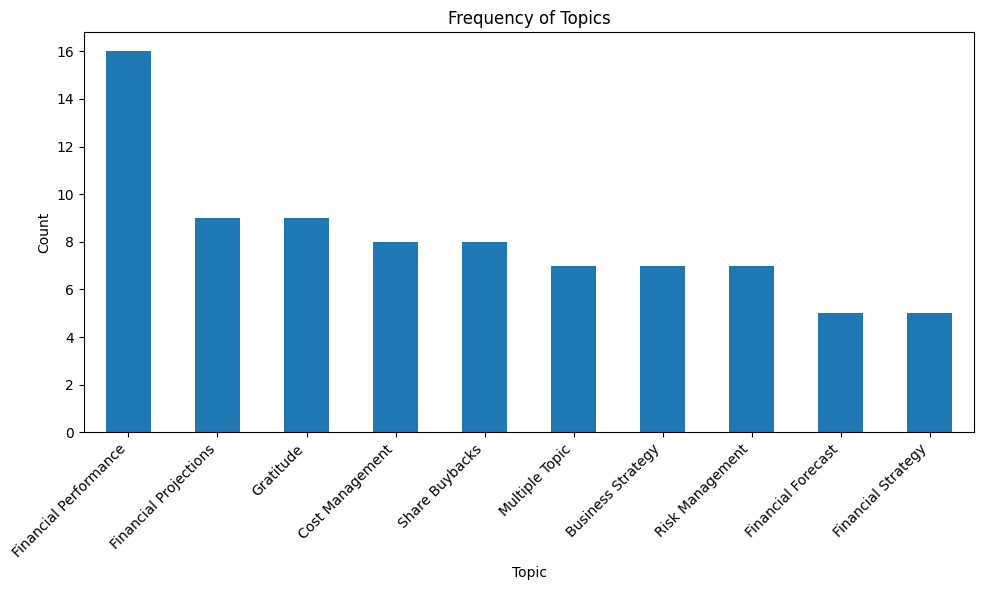

In [ ]:
import matplotlib.pyplot as plt

# Count the frequency of each topic
topic_counts = final_df['Topic'].value_counts().head(10)

# Create a bar plot for the topics
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar')
plt.title('Frequency of Topics')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Observations from the Plots

This plot shows the most frequently discussed topics across the dataset.
The top topics appear significantly more frequently than others, indicating that certain themes dominate analyst discussions.
There is a steep drop after the first few topics, it suggests that only a handful of topics drive the majority of the discussions.

Possible Insights:

If a risk-related topic (e.g., "Financial performance," "Financial projection") is the most frequent, it may indicate the bank's intention to create and manage goodwill.
A high occurrence of strategy-related topics (e.g., "Cost management," "Share buybacks") suggests a focus on business growth and capital allocation decisions.

<Figure size 1200x700 with 0 Axes>

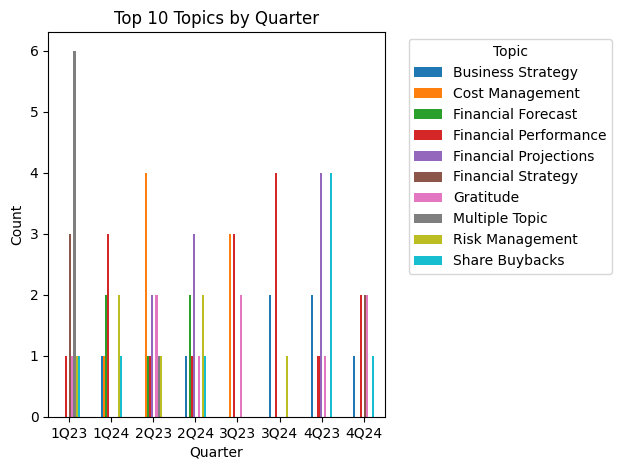

In [ ]:
# Identify the top 10 topics overall
top_topics = final_df['Topic'].value_counts().head(10).index

# Filter the DataFrame for only these top topics
filtered_df = final_df[final_df['Topic'].isin(top_topics)]

# Group the data by Quarter and Topic, counting the occurrences
grouped_data = filtered_df.groupby(['Quarter', 'Topic']).size().unstack(fill_value=0)

# Plot the grouped bar chart
plt.figure(figsize=(12, 7))
grouped_data.plot(kind='bar')
plt.title('Top 10 Topics by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Observation from the plot

This plot illustrates how the dominant discussion topics change over time.
Certain topics remain consistently high across multiple quarters, they represent persistent concerns or strategic focus areas for the banks.
A sharp increase in a topic's frequency in a particular quarter may indicate:
A significant event (e.g., regulatory changes, macroeconomic shifts, major bank announcements).
Analysts' concerns about a specific issue during that time period.
If risk-related topics spike in a specific quarter, it may correspond to market volatility, financial crises, or regulatory changes.
If the mix of topics varies each quarter, it suggests shifting priorities and discussions based on evolving economic conditions.
Possible Insights:

Topics like "Business Strategy" or "Cost management" dominate a particular quarter, it may align with external financial stress (e.g., market downturns, banking crises).
The topics shift from risk-related in earlier quarters to growth-related (e.g., "Financial Strategy," "Share buybacks") in later quarters, it may indicate increasing confidence in the market.

# Section 3: Visualization of Trends & Insights:

<ipython-input-28-10f723d30e37>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bank_data['Analyst_Bank'], rotation=45, ha='right')
<ipython-input-28-10f723d30e37>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bank_data['Analyst_Bank'], rotation=45, ha='right')


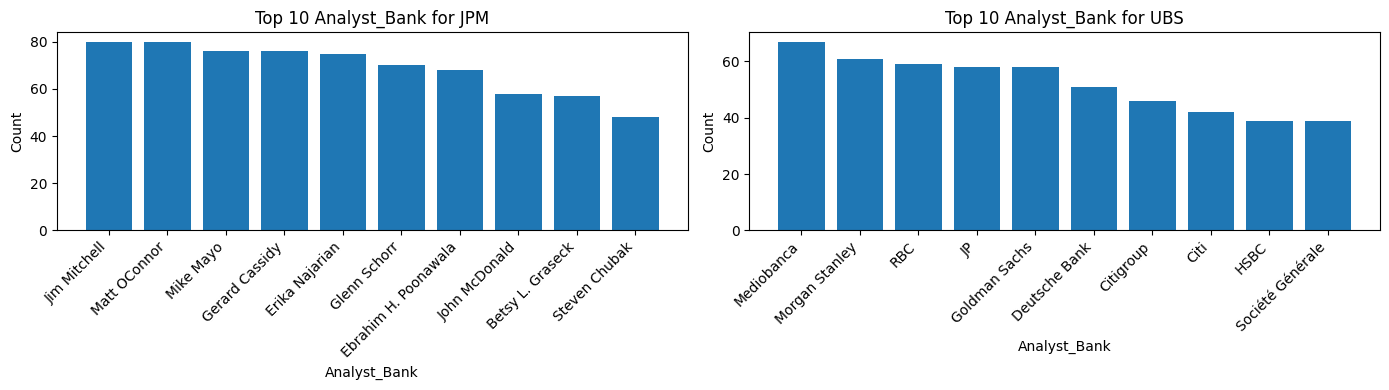

In [ ]:
import math

# Create a working copy of the DataFrame
df = final_df.copy()


# Group by 'Bank' and the complete 'Analyst_Bank' value, and count the occurrences
grouped = df.groupby(['Bank', 'Analyst_Bank']).size().reset_index(name='Count')

# Get the unique banks for iterating over groups
banks = grouped['Bank'].unique()
num_banks = len(banks)

# Set up a grid of subplots (using 2 columns here)
ncols = 2
nrows = math.ceil(num_banks / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(14, nrows * 4), squeeze=False)

# For each bank, plot a bar chart of the top 10 Analyst_Bank entries by count
for i, bank in enumerate(banks):
    ax = axs[i // ncols, i % ncols]
    # Filter and sort the data for the current bank, selecting the top 10 entries
    bank_data = grouped[grouped['Bank'] == bank].sort_values(by='Count', ascending=False).head(10)
    ax.bar(bank_data['Analyst_Bank'], bank_data['Count'])
    ax.set_title(f"Top 10 Analyst_Bank for {bank}")
    ax.set_xlabel("Analyst_Bank")
    ax.set_ylabel("Count")
    ax.set_xticklabels(bank_data['Analyst_Bank'], rotation=45, ha='right')

# Remove any unused subplots in the grid
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axs[j // ncols, j % ncols])

plt.tight_layout()
plt.show()

<ipython-input-29-f4632ee7d492>:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_topics.index, rotation=45, ha='right')
<ipython-input-29-f4632ee7d492>:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_topics.index, rotation=45, ha='right')


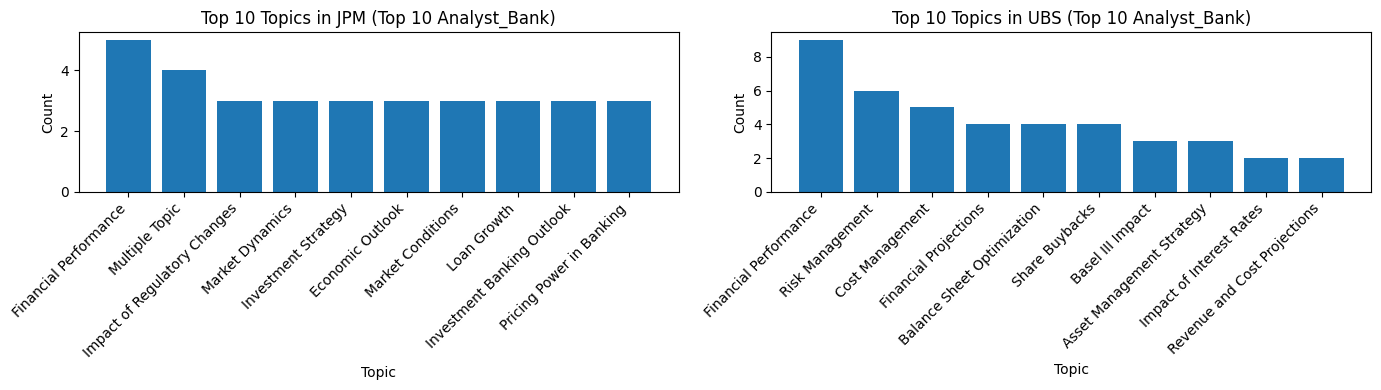

In [ ]:
# Create a working copy of the DataFrame
df = final_df.copy()

# Get the unique banks from the data
banks = df['Bank'].unique()
num_banks = len(banks)

# Set up a grid of subplots (using 2 columns as an example)
ncols = 2
nrows = math.ceil(num_banks / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(14, nrows * 4), squeeze=False)

# Iterate over each bank
for i, bank in enumerate(banks):
    ax = axs[i // ncols, i % ncols]

    # Filter the DataFrame for the current bank
    bank_df = df[df['Bank'] == bank]

    # Identify the top 10 Analyst_Bank entries for this bank
    top_ab = bank_df['Analyst_Bank'].value_counts().head(10).index

    # Filter data to only include rows from the top 10 Analyst_Bank
    filtered_bank_df = bank_df[bank_df['Analyst_Bank'].isin(top_ab)]

    # Group by Topic and count occurrences, then select the top 10 topics
    top_topics = filtered_bank_df['Topic'].value_counts().head(10)

    # Plot the results as a bar chart
    ax.bar(top_topics.index, top_topics.values)
    ax.set_title(f"Top 10 Topics in {bank} (Top 10 Analyst_Bank)")
    ax.set_xlabel("Topic")
    ax.set_ylabel("Count")
    ax.set_xticklabels(top_topics.index, rotation=45, ha='right')

# Remove any unused subplots if present
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axs[j // ncols, j % ncols])

plt.tight_layout()
plt.show()

<ipython-input-30-6055c23f0cbb>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_topics.index, rotation=45, ha='right')
<ipython-input-30-6055c23f0cbb>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_topics.index, rotation=45, ha='right')
<ipython-input-30-6055c23f0cbb>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_topics.index, rotation=45, ha='right')


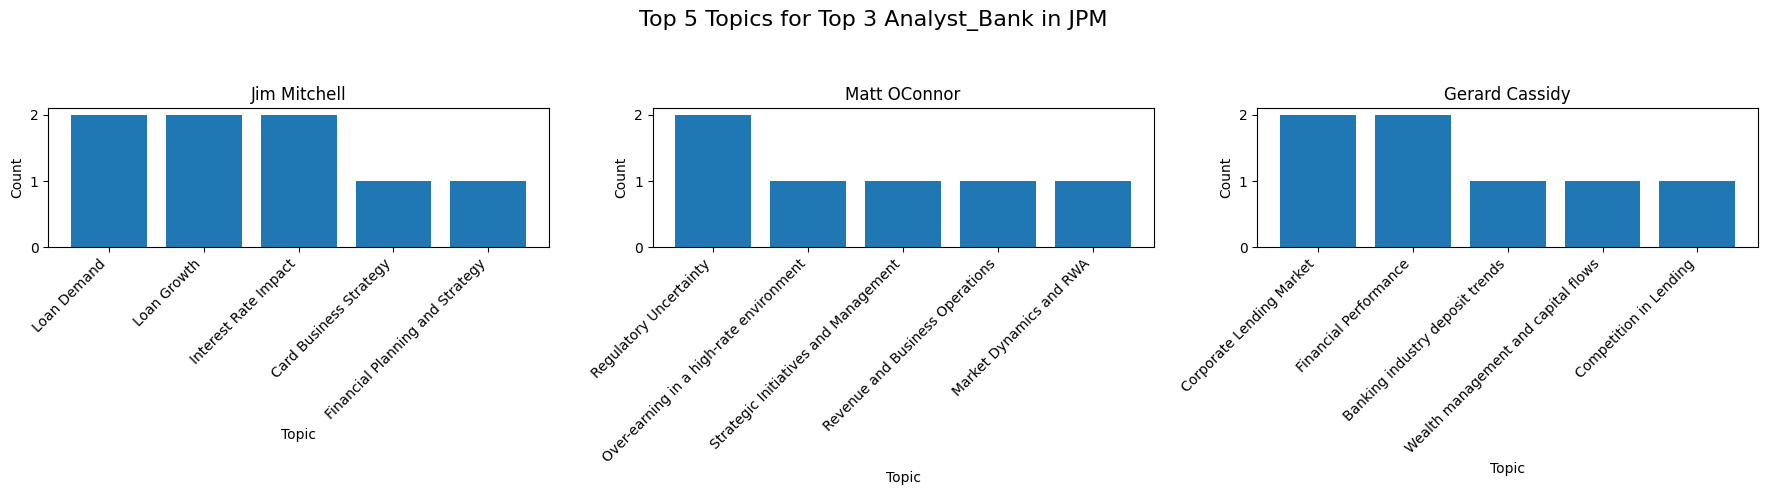

<ipython-input-30-6055c23f0cbb>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_topics.index, rotation=45, ha='right')
<ipython-input-30-6055c23f0cbb>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_topics.index, rotation=45, ha='right')
<ipython-input-30-6055c23f0cbb>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_topics.index, rotation=45, ha='right')


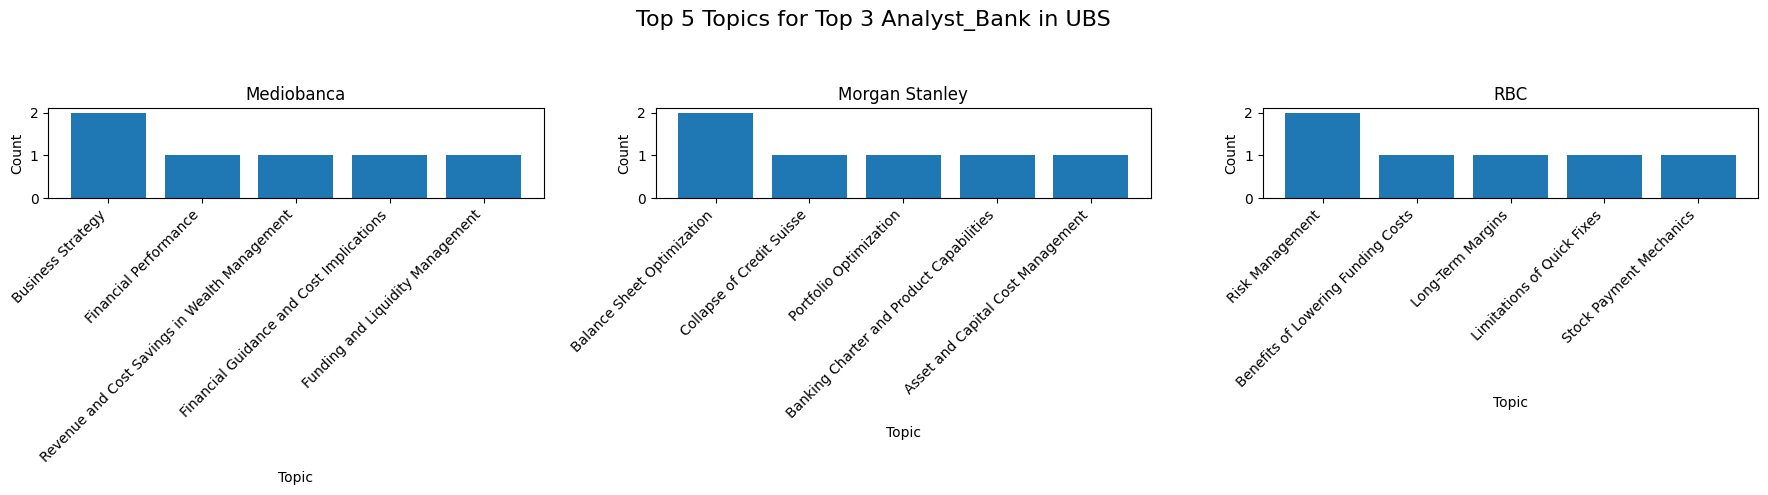

In [ ]:
# Create a working copy of the DataFrame
df = final_df.copy()

# Get the unique banks
banks = df['Bank'].unique()

# Iterate over each bank
for bank in banks:
    # Filter DataFrame for the current bank
    bank_df = df[df['Bank'] == bank]

    # Calculate the top 3 Analyst_Bank entries for this bank
    top_analysts = bank_df['Analyst_Bank'].value_counts().head(3).index

    # Set up a figure with one subplot per top analyst
    fig, axs = plt.subplots(1, len(top_analysts), figsize=(6 * len(top_analysts), 5))

    # If only one subplot exists, put it in a list for consistency
    if len(top_analysts) == 1:
        axs = [axs]

    # For each top Analyst_Bank, plot the top 5 topics
    for ax, analyst in zip(axs, top_analysts):
        # Filter the bank DataFrame for the current Analyst_Bank
        analyst_df = bank_df[bank_df['Analyst_Bank'] == analyst]

        # Calculate the top 5 topics for this Analyst_Bank
        top_topics = analyst_df['Topic'].value_counts().head(5)

        # Create the bar chart for top topics
        ax.bar(top_topics.index, top_topics.values)
        ax.set_title(analyst)
        ax.set_xlabel("Topic")
        ax.set_ylabel("Count")
        ax.set_xticklabels(top_topics.index, rotation=45, ha='right')

    # Add a super title for the bank group and adjust layout
    fig.suptitle(f"Top 5 Topics for Top 3 Analyst_Bank in {bank}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

Observation form the above plots

**Top 5 Topics by Top 3 Analyst_Bank (JPM)**
This plot highlights the most discussed topics by the top 3 analysts covering JPMorgan.
The analysts are probing JP Morgan with market related topics such as 'Loan demand', 'Regulatory uncertainity' and 'Risk Management'. On a high level all these topics does not reveal good or strong confidence of analsysts on the bank.

Analyst Jim Mitchel and Gerard Cassidy showed strong focs on 2 themes. These Loan and regulatory concerns. It revelas that they want to emphaisze in these topics which may be concern for them for a long time.

**Top 5 Topics by Top 3 Analyst_Bank (UBS)**

This plot provides a similar breakdown but for UBS.

If UBS's top analysts focus on different topics than JPMorgan’s analysts, it suggests bank-specific concerns or strategies.

There is no topics overlap with JPMorgan’s, it might indicate that every bank is facing their own challenges and analysts are well aware of their challenges and questioning on lon term challenges.
A strong focus on business strategy and balance sheet optimization topics suggests UBS is being evaluated for its growth potential and capital efficiency.
Analysts discuss financial performance and credit score issues more than JPM analysts, it might indicate UBS’s greater exposure to global market risks.

Possible Insights:

UBS analysts discuss financial performance and busienss strategies, it suggests a focus on growth opportunities.
A high emphasis on compliance or risk may indicate regulatory pressures or internal restructuring.


<ipython-input-31-eb9a9932eb45>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_topics.index, rotation=45, ha='right')
<ipython-input-31-eb9a9932eb45>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_topics.index, rotation=45, ha='right')


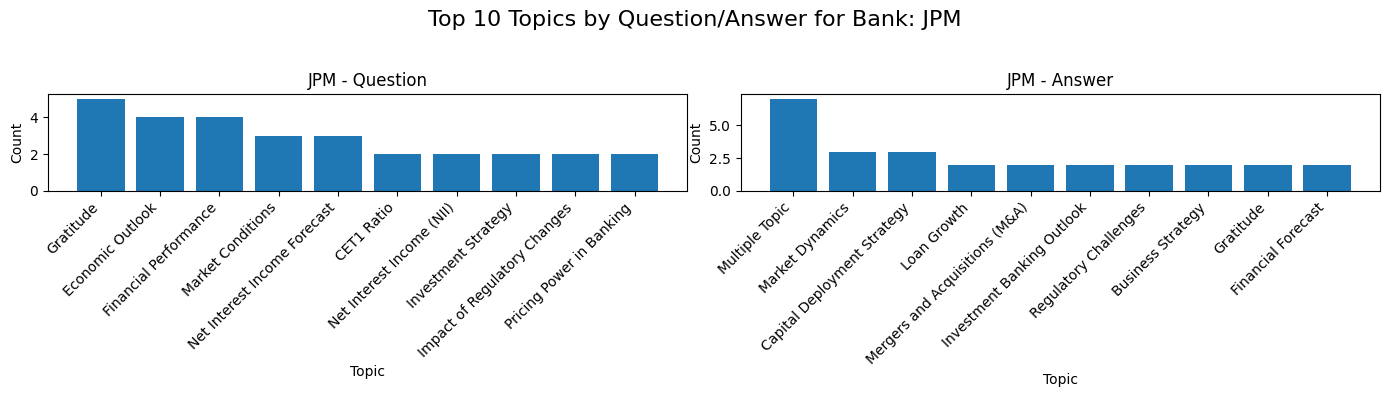

<ipython-input-31-eb9a9932eb45>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_topics.index, rotation=45, ha='right')
<ipython-input-31-eb9a9932eb45>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_topics.index, rotation=45, ha='right')


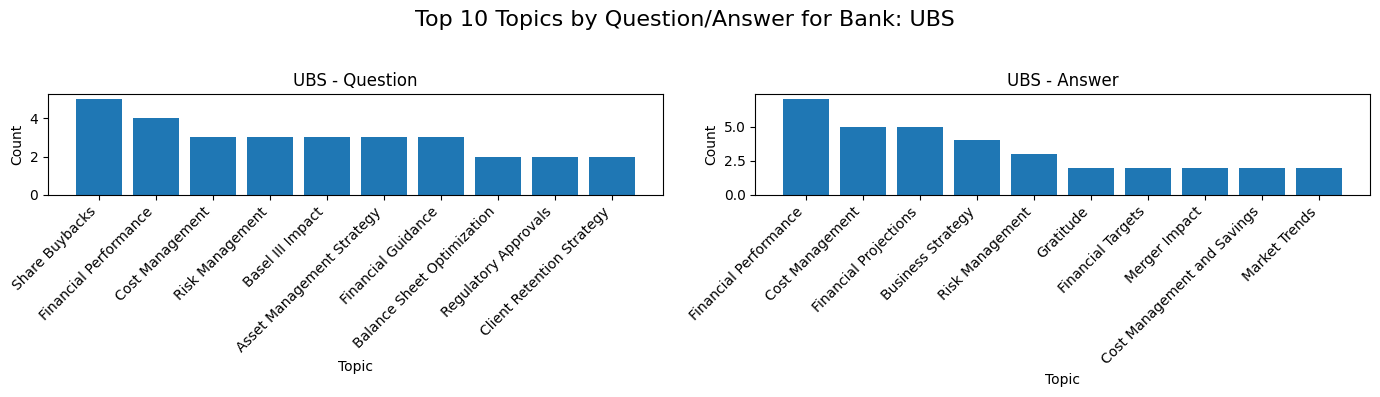

In [ ]:
# Create a working copy of the DataFrame
df = final_df.copy()


# Get the unique banks
banks = df['Bank'].unique()

# Iterate over each bank
for bank in banks:
    bank_df = df[df['Bank'] == bank]

    # Get unique Question/Answer groups for the current bank.
    # Ensure the 'Question/Answer' column exists in your DataFrame.
    qa_groups = bank_df['Question/Answer'].unique()

    # Setup subplots for each Question/Answer group in the current bank.
    ncols = 2  # adjust number of columns as desired
    nrows = math.ceil(len(qa_groups) / ncols)
    fig, axs = plt.subplots(nrows, ncols, figsize=(14, nrows * 4), squeeze=False)

    # Iterate over each Question/Answer group and plot top 10 topics
    for i, qa in enumerate(qa_groups):
        ax = axs[i // ncols, i % ncols]
        qa_df = bank_df[bank_df['Question/Answer'] == qa]
        top_topics = qa_df['Topic'].value_counts().head(10)

        ax.bar(top_topics.index, top_topics.values)
        ax.set_title(f"{bank} - {qa}")
        ax.set_xlabel("Topic")
        ax.set_ylabel("Count")
        ax.set_xticklabels(top_topics.index, rotation=45, ha='right')

    # Remove any unused subplots in the grid
    total_plots = nrows * ncols
    for j in range(len(qa_groups), total_plots):
        fig.delaxes(axs[j // ncols, j % ncols])

    fig.suptitle(f"Top 10 Topics by Question/Answer for Bank: {bank}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

**JPM - Question Panel (Left Chart)**

The most frequently asked topic is "Gratitude", which might indicate formal expressions of appreciation before questions.
Analysts focused on economic and financial performance, with topics like:
"Economic Outlook" – indicating concerns about macroeconomic conditions.
"Financial Performance" & "Market Conditions" – suggesting a focus on JPMorgan’s business performance and market environment.
"Net Interest Income Forecast" – implying analysts are keen on understanding JPMorgan’s future earnings from lending activities.
Regulatory and strategic concerns are also present, including:
"CET1 Ratio" – a key regulatory capital requirement.
"Impact of Regulatory Changes" – indicating potential concerns about compliance and evolving financial regulations.
"Pricing Power in Banking" – suggesting interest in how JPMorgan manages interest rates and pricing strategies.

**JPM - Answer Panel (Right Chart)**

The most discussed topic in responses is "Multiple Topic", implying that many responses cover multiple issues rather than single concerns.
Strategic and financial matters dominate JPMorgan’s responses, including:
"Market Dynamics" – discussing JPMorgan’s position in changing economic conditions.
"Capital Deployment Strategy" – indicating how JPMorgan is allocating its financial resources.
"Loan Growth" – reflecting the bank’s stance on lending expansion.
"Mergers and Acquisitions (M&A)" – hinting at JPMorgan’s involvement or interest in industry consolidations.
"Investment Banking Outlook" – likely covering JPMorgan’s growth plans in investment banking.
Regulatory discussions remain relevant, with:
"Regulatory Challenges" being a key topic.
Business and financial strategies are also prominent, such as:
"Business Strategy" and "Financial Forecast", showing JPMorgan’s emphasis on future planning.

**UBS - Question Panel (Left Chart)**

The most frequently asked topic is "Share Buybacks", indicating that analysts are particularly interested in UBS’s capital return strategy.
Analysts also focus on UBS’s financial health and efficiency, with topics such as:
"Financial Performance" – suggesting an emphasis on UBS’s earnings and revenue growth.
"Cost Management" – indicating concerns about UBS’s expense control and profitability.
"Risk Management" & "Basel III Impact" – pointing to concerns about regulatory capital requirements and UBS’s risk exposure.
"Asset Management Strategy" – showing interest in UBS’s investment and portfolio management strategies.
Discussions around "Balance Sheet Optimization" and "Regulatory Approvals" suggest a focus on UBS’s capital structure and compliance.
"Client Retention Strategy" appearing in the top 10 suggests that analysts are interested in UBS’s ability to retain and grow its customer base.

**UBS - Answer Panel (Right Chart)**

UBS’s responses focus heavily on financial discipline and business strategy, with the most frequent topics being:
"Financial Performance" – aligning with analysts' concerns.
"Cost Management" – a key topic in both questions and answers, indicating UBS’s active focus on efficiency.
"Financial Projections" – showing UBS’s intent to provide forward-looking guidance.
"Business Strategy" – suggesting UBS frames many of its responses in a broader strategic context.
Risk management remains a key topic, implying UBS acknowledges regulatory concerns but does not overemphasize them.
Other key discussion points:
"Merger Impact" – indicating discussions around acquisitions or business integrations.
"Cost Management and Savings" – reinforcing UBS’s emphasis on efficiency.
"Market Trends" – indicating responses tailored to broader economic and financial conditions.

<ipython-input-32-c722abbd2b61>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_topics.index, rotation=45, ha='right')
<ipython-input-32-c722abbd2b61>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_topics.index, rotation=45, ha='right')
<ipython-input-32-c722abbd2b61>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_topics.index, rotation=45, ha='right')


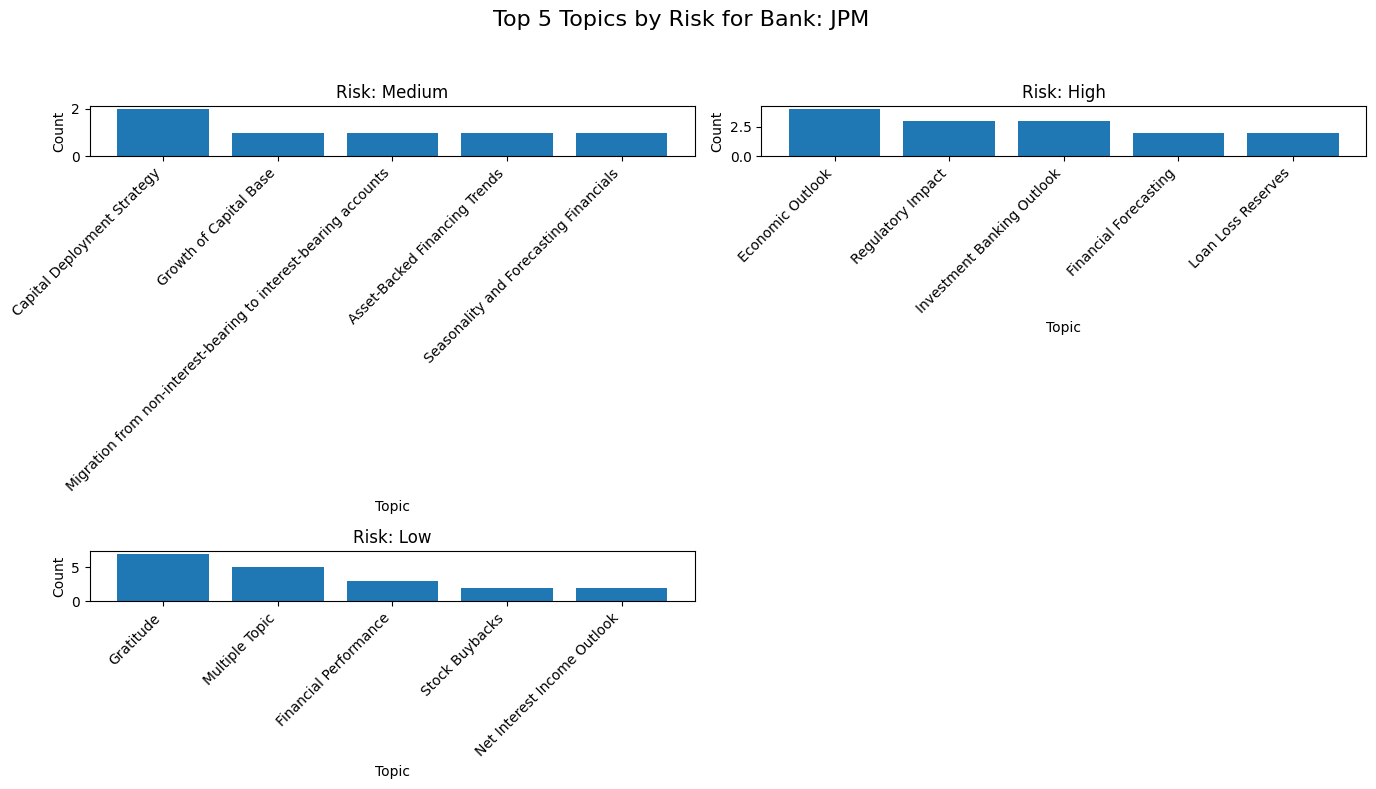

<ipython-input-32-c722abbd2b61>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_topics.index, rotation=45, ha='right')
<ipython-input-32-c722abbd2b61>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_topics.index, rotation=45, ha='right')
<ipython-input-32-c722abbd2b61>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_topics.index, rotation=45, ha='right')
<ipython-input-32-c722abbd2b61>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_topics.index, rotation=45, ha='right')


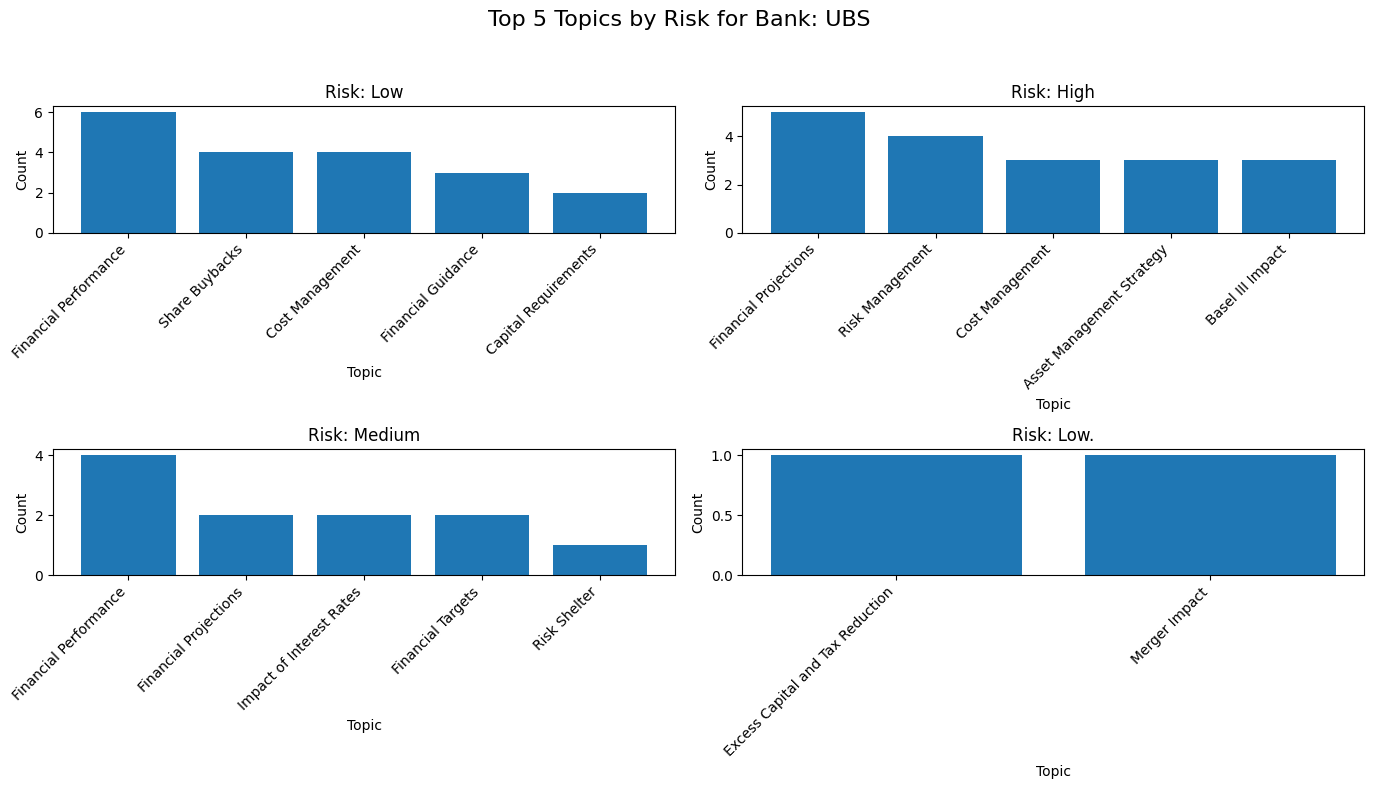

In [ ]:
# Get all unique banks from the DataFrame
banks = final_df['Bank'].unique()

# Iterate over each bank
for bank in banks:
    bank_df = final_df[final_df['Bank'] == bank]
    risk_values = bank_df['Risk'].unique()

    # Set up subplots for each risk group for the current bank.
    ncols = 2  # adjust number of columns as needed
    nrows = math.ceil(len(risk_values) / ncols)
    fig, axs = plt.subplots(nrows, ncols, figsize=(14, nrows * 4), squeeze=False)

    # Iterate over each risk level within the bank group
    for i, risk in enumerate(risk_values):
        ax = axs[i // ncols, i % ncols]
        risk_df = bank_df[bank_df['Risk'] == risk]
        top_topics = risk_df['Topic'].value_counts().head(5)

        # Create a bar chart of the top 5 topics for this risk category
        ax.bar(top_topics.index, top_topics.values)
        ax.set_title(f"Risk: {risk}")
        ax.set_xlabel("Topic")
        ax.set_ylabel("Count")
        ax.set_xticklabels(top_topics.index, rotation=45, ha='right')

    # Remove any extra subplots if present
    total_plots = nrows * ncols
    for j in range(i + 1, total_plots):
        fig.delaxes(axs[j // ncols, j % ncols])

    # Add an overall title for the current bank group and adjust layout
    fig.suptitle(f"Top 5 Topics by Risk for Bank: {bank}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

**Risk: High (Top-Right Chart)**

Most frequent topics:
Economic Outlook – Indicates that high-risk discussions are closely tied to macroeconomic conditions.
Regulatory Impact – Suggests that regulatory compliance and policy changes are major concerns in high-risk discussions.
Investment Banking Outlook – Reflects concerns about the performance and future trends in investment banking.
Financial Forecasting – Highlights the need to assess future earnings and financial risks.
Loan Loss Reserves – Points to concerns about potential credit losses and financial stability.
Possible Insights:
Discussions in the high-risk category tend to focus on macro-level financial health and regulatory uncertainties.
The presence of loan loss reserves and financial forecasting suggests an emphasis on credit risk and potential economic downturn scenarios.
Investment banking outlook appearing in high-risk discussions may indicate concerns about market volatility and deal-making risks.

**Risk: Medium (Top-Left Chart)**

Most frequent topics:
Capital Deployment Strategy – Indicates discussions about how financial resources are allocated in a moderate-risk setting.
Growth of Capital Base – Suggests that discussions involve balancing risk while expanding the bank’s financial strength.
Migration from Non-Interest-Bearing to Interest-Bearing Accounts – Reflects concerns about liquidity shifts and profitability management.
Asset-Backed Financing Trends – Highlights the focus on structured finance and leveraging assets for capital efficiency.
Seasonality and Forecasting Financials – Points to discussions around predictable market fluctuations and their impact on business strategies.
Possible Insights:
Medium-risk discussions focus more on capital strategy and structured financing rather than direct financial distress.
A shift in deposit types (migration to interest-bearing accounts) indicates profitability management under moderate risk conditions.
Seasonality appearing in this category suggests that financial trends and forecasting models are crucial in managing moderate risks.

**Risk: Low (Bottom Chart)**

Most frequent topics:
Gratitude – This suggests that low-risk discussions are more formal and less contentious, often involving acknowledgments.
Multiple Topic – Implies that low-risk discussions cover a broader range of issues without focusing heavily on a specific risk factor.
Financial Performance – Indicates that standard earnings and revenue discussions fall under the low-risk category.
Stock Buybacks – Suggests that capital return strategies (such as repurchasing shares) are seen as low-risk financial decisions.
Net Interest Income Outlook – Suggests that interest rate trends and income from lending are stable, with minimal perceived risk.
Possible Insights:
Low-risk topics tend to focus on financial performance and capital return, implying confidence in stability.
Stock buybacks appearing in the low-risk category reinforces the idea that shareholder returns are not considered a major financial risk.
The inclusion of "Multiple Topics" suggests that general discussions with no significant financial threat fall into this category.
Key Takeaways
High-risk discussions focus on economic conditions, regulatory challenges, and financial forecasting, indicating concerns about external market risks.
Medium-risk topics center around capital deployment, liquidity shifts, and financing trends, suggesting more strategic financial planning.
Low-risk discussions involve general financial performance, stock buybacks, and net interest income, reflecting a stable, less concerning financial outlook.
Loan loss reserves and investment banking in the high-risk category suggest potential volatility in credit and market-driven revenues.
The presence of capital growth and deployment in medium-risk discussions highlights strategic decisions that require balanced risk management.

    Bank Quarter     Macro Topic  Count
0    JPM    1Q23  Total exposure     27
10   JPM    1Q24  Total exposure     41
21   JPM    2Q23  Total exposure     49
33   JPM    2Q24  Total exposure     37
43   JPM    3Q23  Total exposure     47
53   JPM    3Q24  Total exposure     26
63   JPM    4Q23  Total exposure     29
75   JPM    4Q24  Total exposure     34
85   UBS    1Q23  Total exposure     64
94   UBS    1Q24  Total exposure     63
105  UBS    2Q23  Total exposure     72
112  UBS    2Q24  Total exposure     56
120  UBS    3Q23  Total exposure     42
130  UBS    3Q24  Total exposure     55
139  UBS    4Q23  Total exposure     90
150  UBS    4Q24  Total exposure     61


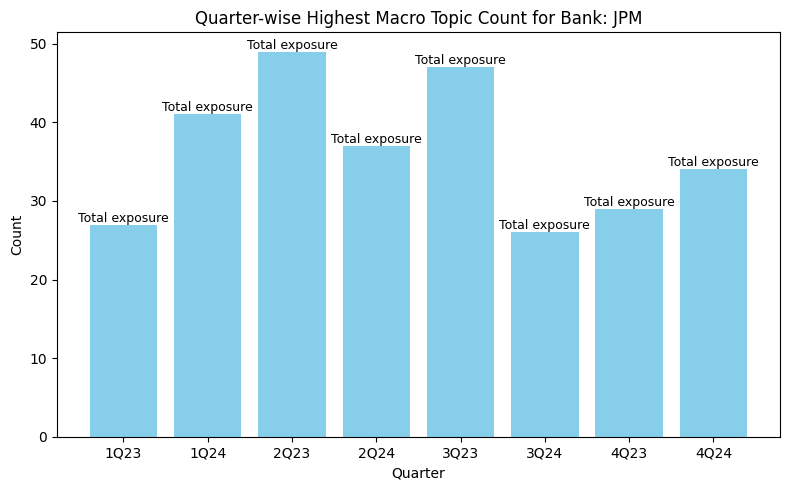

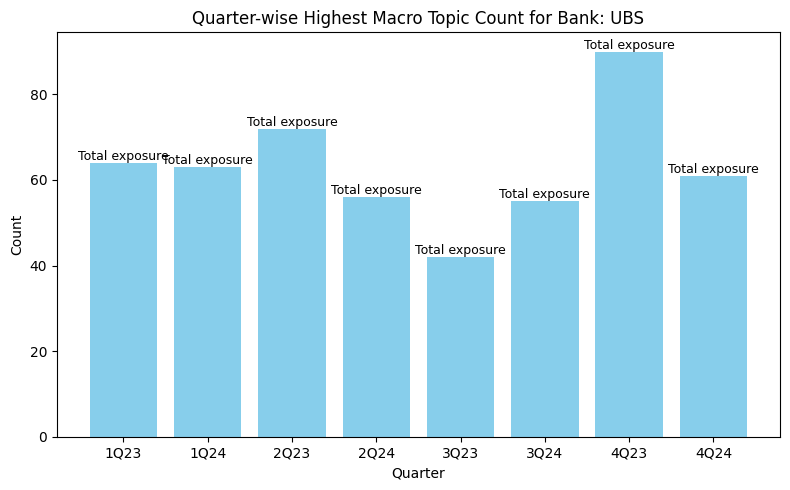

In [ ]:
# Group by Bank and Quarter, and count occurrences of each 'Macro Topic'
grouped = final_df.groupby(['Bank', 'Quarter'])['Macro Topic'].value_counts().reset_index(name='Count')

# For each Bank and Quarter, select the row with the highest count (i.e., the top Macro Topic)
top_macro_topic = grouped.loc[grouped.groupby(['Bank', 'Quarter'])['Count'].idxmax()]

# Display the results
print(top_macro_topic)

# Optionally, plot the highest Macro Topic count per Quarter for each Bank
banks = top_macro_topic['Bank'].unique()
for bank in banks:
    bank_data = top_macro_topic[top_macro_topic['Bank'] == bank].sort_values('Quarter')

    plt.figure(figsize=(8, 5))
    plt.bar(bank_data['Quarter'].astype(str), bank_data['Count'], color='skyblue')

    # Annotate the bars with the Macro Topic label
    for _, row in bank_data.iterrows():
        plt.text(str(row['Quarter']), row['Count'], row['Macro Topic'],
                 ha='center', va='bottom', fontsize=9)

    plt.title(f"Quarter-wise Highest Macro Topic Count for Bank: {bank}")
    plt.xlabel("Quarter")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

Based on G-SIB assesment criteria, the 'Total Exposure' which has 20% weightage in the evaluation is dominantly present in all the years

    Bank Quarter High Level Topic  Count
0    JPM    1Q23           Equity     17
7    JPM    1Q24           Equity     54
18   JPM    2Q23           Equity     30
28   JPM    2Q24           Equity     39
38   JPM    3Q23           Equity     35
49   JPM    3Q24           Equity     31
61   JPM    4Q23           Equity     29
73   JPM    4Q24           Equity     33
83   UBS    1Q23           Equity     42
93   UBS    1Q24           Equity     40
104  UBS    2Q23           Equity     32
114  UBS    2Q24           Equity     22
124  UBS    3Q23           Equity     16
133  UBS    3Q24           Equity     36
143  UBS    4Q23           Equity     63
153  UBS    4Q24           Equity     33


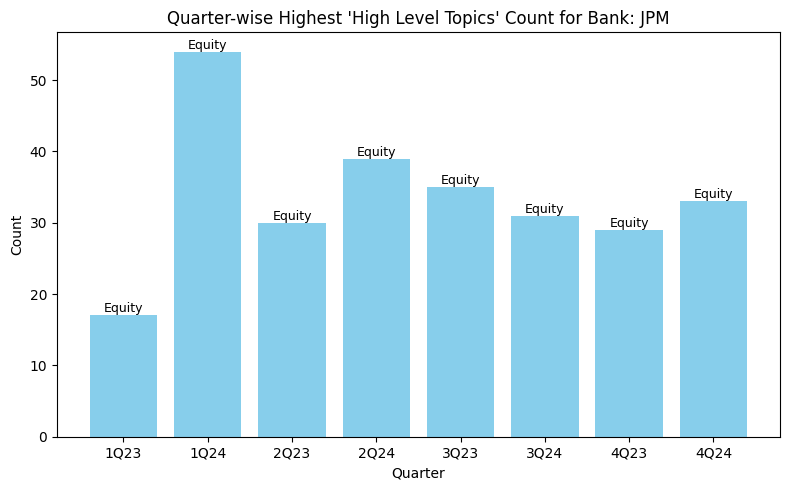

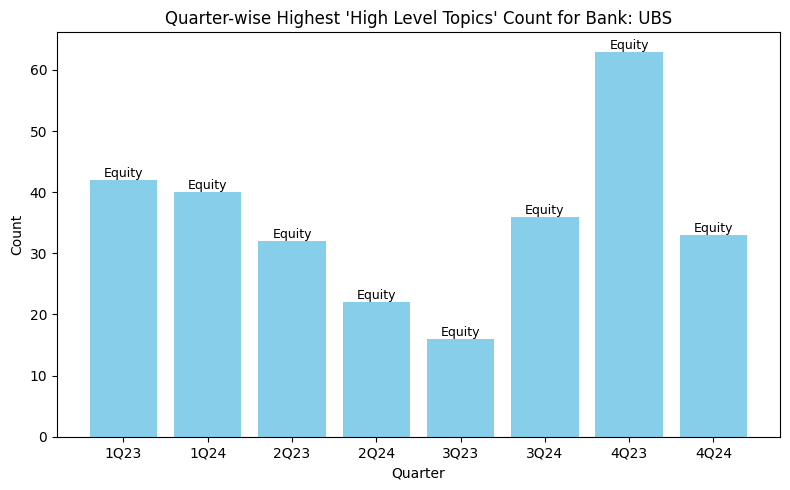

In [ ]:
# Group by Bank and Quarter, then count occurrences of each 'High Level Topics'
grouped = final_df.groupby(['Bank', 'Quarter'])['High Level Topic']\
                  .value_counts().reset_index(name='Count')

# For each Bank and Quarter, select the row with the highest count
top_high_level = grouped.loc[grouped.groupby(['Bank', 'Quarter'])['Count'].idxmax()]

# Print the resulting DataFrame
print(top_high_level)

# Optionally, plot the highest count High Level Topics for each bank per quarter
banks = top_high_level['Bank'].unique()
for bank in banks:
    bank_data = top_high_level[top_high_level['Bank'] == bank].sort_values('Quarter')

    plt.figure(figsize=(8, 5))
    plt.bar(bank_data['Quarter'].astype(str), bank_data['Count'], color='skyblue')

    # Annotate each bar with the corresponding High Level Topic label
    for _, row in bank_data.iterrows():
        plt.text(str(row['Quarter']), row['Count'], row['High Level Topic'],
                 ha='center', va='bottom', fontsize=9)

    plt.title(f"Quarter-wise Highest 'High Level Topics' Count for Bank: {bank}")
    plt.xlabel("Quarter")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

Based on the high level topics, Both banks focus only on 'Equity' to keep goodwill and confidence of shareholders while presenting quarterly figures

# Section 4: Insights Extraction by interactive dashboard

In [ ]:
# Create filter widgets with an "All" option for each
hl_topic_widget = widgets.Dropdown(
    options=['All'] + sorted(final_df['High Level Topic'].dropna().unique().tolist()),
    description="High Level Topic:"
)
macro_topic_widget = widgets.Dropdown(
    options=['All'] + sorted(final_df['Macro Topic'].dropna().unique().tolist()),
    description="Macro Topic:"
)
bank_widget = widgets.Dropdown(
    options=['All'] + sorted(final_df['Bank'].dropna().unique().tolist()),
    description="Bank:"
)
analyst_bank_widget = widgets.Dropdown(
    options=['All'] + sorted(final_df['Analyst_Bank'].dropna().unique().tolist()),
    description="Analyst_Bank:"
)
risk_widget = widgets.Dropdown(
    options=['All'] + sorted(final_df['Risk'].dropna().unique().tolist()),
    description="Risk:"
)

def update_plots(hl_topic, macro_topic, bank, analyst_bank, risk):
    # Start with the full DataFrame copy
    df = final_df.copy()

    # Apply filters if a specific value (not 'All') is chosen
    if hl_topic != 'All':
        df = df[df['High Level Topic'] == hl_topic]
    if macro_topic != 'All':
        df = df[df['Macro Topic'] == macro_topic]
    if bank != 'All':
        df = df[df['Bank'] == bank]
    if analyst_bank != 'All':
        df = df[df['Analyst_Bank'] == analyst_bank]
    if risk != 'All':
        df = df[df['Risk'] == risk]

    # Separate the DataFrame into 'Question' and 'Answer' subsets
    df_question = df[df['Question/Answer'] == 'Question']
    df_answer = df[df['Question/Answer'] == 'Answer']

    # Group by Quarter and count occurrences of 'Topic'
    question_counts = df_question.groupby('Quarter')['Topic'].count()
    answer_counts = df_answer.groupby('Quarter')['Topic'].count()

    # Clear previous output before plotting new results
    clear_output(wait=True)

    # Create two side-by-side bar plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].bar(question_counts.index.astype(str), question_counts.values, color='skyblue')
    axes[0].set_title("Questions by Quarter")
    axes[0].set_xlabel("Quarter")
    axes[0].set_ylabel("Count of Topics")

    axes[1].bar(answer_counts.index.astype(str), answer_counts.values, color='lightgreen')
    axes[1].set_title("Answers by Quarter")
    axes[1].set_xlabel("Quarter")
    axes[1].set_ylabel("Count of Topics")

    plt.tight_layout()
    plt.show()

# Create the interactive widget
interactive_plot = widgets.interactive(
    update_plots,
    hl_topic=hl_topic_widget,
    macro_topic=macro_topic_widget,
    bank=bank_widget,
    analyst_bank=analyst_bank_widget,
    risk=risk_widget
)

# Display the interactive controls and plot
display(interactive_plot)

interactive(children=(Dropdown(description='High Level Topic:', options=('All', 'Acquisition', 'Balance', 'Bal…

# **Key insights from interactive dashboard**

This interactive dashboard visualizes high-risk equity-related discussions between HSBC analysts and UBS executives across 3Q24 and 4Q24. The left chart shows that the number of questions remained stable across both quarters, indicating consistent analyst interest in high-risk equity topics. However, the right chart reveals that UBS provided more responses in 4Q24 compared to 3Q24, suggesting an increase in engagement or clarification on previously raised concerns. This trend may indicate that UBS executives became more responsive or that evolving market conditions necessitated more detailed explanations in the later quarter.